In [ ]:
pip install lightfm

In [ ]:
pip install annoy

## <center> Content-based recommender models </center>

In [ ]:
import warnings

warnings.filterwarnings("ignore")
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

import collections
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from itertools import islice, cycle, product
from lightfm.data import Dataset
from lightfm import LightFM
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm_notebook
from annoy import AnnoyIndex
#from utils.data import MatchDataGenerator, df_to_dict
#from utils.basic_layers import MLP, EmbeddingLayer
#from utils.features import SparseFeature, SequenceFeature
#from utils.match import Annoy, generate_seq_feature_match, gen_model_input
#from utils.metrics import topk_metrics
#from utils.trainer import MatchTrainer

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
torch.manual_seed(42)

**Ключевая идея** - попробуем учиться не только на взаимодействиях users и items, но и добавлять в модель имеющиеся по ним признаки.

Способов немало, но наиболее интересные и распространенные модели:
- DSSM и ее адаптации
- LightFM

## DSSM (Deep Structured Semantic Model)

Вспомним, как выглядела оригинальная модель DSSM для задачи ранжирования выдачи поиска.  

<img src='https://kishorepv.github.io/images/DSSM_layers.png' width=700>

где $R(Q, D) = cosine(y_{Q}, y_{D}) = \dfrac{y_{Q}^{T} y_{D}}{||y_{Q}|| \cdot ||y_{D}||}$.

При этом, считаем оценку семантической релевантности текущего документа и запроса как:

$$P(D|Q) = \frac{exp(\gamma R(Q, D))}{\sum_{D' \in D}exp(\gamma R(Q, D') }$$

Проблема со знаменателем давно известна, поэтому минимизировать будем следующую функцию:

$$L (Λ) = - log \prod_{(Q, D^{+})} P(D^{+}|Q)$$

Слева - уже знакомая нам постановка задачи для матричной факторизации. Справа - как можем модифицировать DSSM под решение задачи рекомендаций и с обогащением признаками.


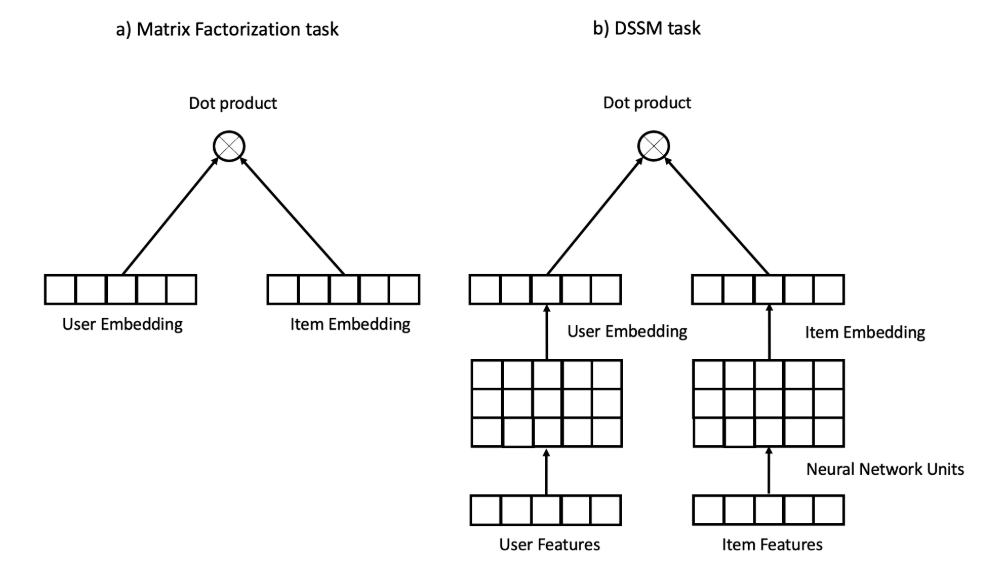

In [ ]:
"""
References:
    paper: (CIKM'2013) Learning Deep Structured Semantic Models for Web Search using Clickthrough Data
    url: https://posenhuang.github.io/papers/cikm2013_DSSM_fullversion.pdf
    code: https://github.com/bbruceyuan/DeepMatch-Torch/blob/main/deepmatch_torch/models/dssm.py
"""


class DSSM(torch.nn.Module):
    """Deep Structured Semantic Model
    Args:
        user_features (list[Feature Class]): training by the user tower module.
        item_features (list[Feature Class]): training by the item tower module.
        temperature (float): temperature factor for similarity score, default to 1.0.
        user_params (dict): the params of the User Tower module,
        keys include:`{"dims":list, "activation":str, "dropout":float, "output_layer":bool`}.
        item_params (dict): the params of the Item Tower module,
        keys include:`{"dims":list, "activation":str, "dropout":float, "output_layer":bool`}.
    """

    def __init__(self, user_features, item_features, user_params, item_params, temperature=1.0):
        super().__init__()
        self.user_features = user_features
        self.item_features = item_features
        self.temperature = temperature
        self.user_dims = sum([f.embed_dim for f in user_features])
        self.item_dims = sum([f.embed_dim for f in item_features])

        self.embedding = EmbeddingLayer(user_features + item_features)
        self.user_mlp = MLP(self.user_dims, output_layer=False, **user_params)
        self.item_mlp = MLP(self.item_dims, output_layer=False, **item_params)
        self.mode = None

    def forward(self, x):
        # (b_size, d)
        user_embedding = self.user_tower(x)
        item_embedding = self.item_tower(x)
        if self.mode == "user":
            return user_embedding
        if self.mode == "item":
            return item_embedding
        # (batch_size)
        y = torch.sum(user_embedding * item_embedding, dim=1) * self.temperature

        return torch.sigmoid(y)

    def item_tower(self, x):
        if self.mode == "user":
            return None
        # Какая тут размерность?
        input_item = self.embedding(x, self.item_features, squeeze_dim=True)
        item_embedding = self.item_mlp(input_item)
        item_embedding = F.normalize(item_embedding, p=2, dim=1)
        return item_embedding

    def user_tower(self, x):
        if self.mode == "item":
            return None
        input_user = self.embedding(x, self.user_features, squeeze_dim=True)
        user_embedding = self.user_mlp(input_user)
        user_embedding = F.normalize(user_embedding, p=2, dim=1)
        return user_embedding

* Про температуру

Обычно, при более высокой температуре вероятности становятся более равномерными, что означает, что модель более "размазывает" вероятности между различными классами или вариантами ответов.

Сравните ее еще раз с архитектурами DSSM и CF (ч.с. MF)


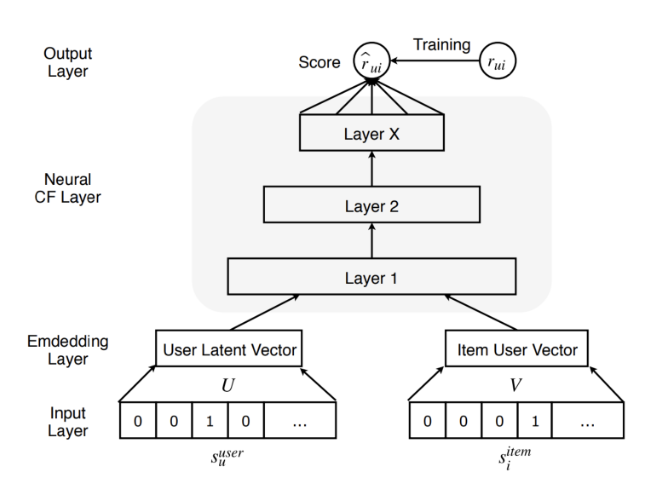

Есть много имплементаций DSSM, можно посмотреть, например, в библиотеке [RecBole](https://github.com/RUCAIBox/RecBole/blob/4b6c6fef9b2f21326876f81e5d76631b280b0909/recbole/model/context_aware_recommender/dssm.py)

* Подумайте, какие варианты negative sampling при оптимизации лосса тут можно использовать?

* Какие признаки можно использовать по users, items в качестве input данных?

* Какие преимущества и недостатки у DSSM модели?


| Метод | Достоинства  |  Недостатки |
|---|---|---|
| DSSM| Может выявить нелинейные закономерности  |  Дополнительная работа с признаками и оценкой их вклада|  
|
|| Real-time inference на проде | Необходимость подбора параметров и тюнинга гиперпараметров |  
|
|| Возможность добавлять признаки разного типа| Уже вряд ли можно назвать SOTA по качеству ранжирования |
|
|| User и item эмбеддинги в едином векторном пространстве| |  

## Вспомогательные модули для запуска

In [ ]:
class Dice(nn.Module):
    """The Dice activation function
    https://arxiv.org/abs/1706.06978
    """

    def __init__(self, epsilon=1e-3):
        super(Dice, self).__init__()
        self.epsilon = epsilon
        self.alpha = nn.Parameter(torch.randn(1))

    def forward(self, x: torch.Tensor):
        avg = x.mean(dim=1)
        avg = avg.unsqueeze(dim=1)
        var = torch.pow(x - avg, 2) + self.epsilon
        var = var.sum(dim=1).unsqueeze(dim=1)

        ps = (x - avg) / torch.sqrt(var)

        ps = nn.Sigmoid()(ps)  # N * 1
        return ps * x + (1 - ps) * self.alpha * x


def activation_layer(act_name):
    """
    Args:
        act_name: str or nn.Module, name of activation function

    Returns:
        act_layer: activation layer
    """
    act_layers = {'sigmoid' : nn.Sigmoid(),
                 'relu' : nn.ReLU(inplace=True),
                 'dice': Dice(),
                 'prelu': nn.PReLU(),
                 "softmax": nn.Softmax(dim=1)}

    if isinstance(act_name, str):
        act_layer = act_layers[act_name.lower()]
    elif issubclass(act_name, nn.Module):
        act_layer = act_name()
    else:
        raise NotImplementedError
    return act_layer


In [ ]:
class PredictionLayer(nn.Module):
    """
    Args:
        task_type (str): returns sigmoid(x) for classification and x for regression tasks.
    """

    def __init__(self, task_type='classification'):
        super(PredictionLayer, self).__init__()
        if task_type not in ["classification", "regression"]:
            raise ValueError("task_type must be classification or regression")
        self.task_type = task_type

    def forward(self, x):
        if self.task_type == "classification":
            x = torch.sigmoid(x)
        return x


class EmbeddingLayer(nn.Module):
    """
    All the feature embeddings are saved in embed_dict: `{feature_name : embedding table}`.

    Args:
        features (list): the list of `Feature Class`. It is means all the features which we want to create a embedding table.
    Shape:
        - Input:
            x (dict): {feature_name: feature_value}, sequence feature value is a 2D tensor with shape:`(batch_size, seq_len)`,\
                      sparse/dense feature value is a 1D tensor with shape `(batch_size)`.
            features (list): the list of `Feature Class`. It is means the current features which we want to do embedding lookup.
            squeeze_dim (bool): whether to squeeze dim of output (default = `False`).
        - Output:
            - if input Dense: `(batch_size, num_features_dense)`.
            - if input Sparse: `(batch_size, num_features, embed_dim)` or  `(batch_size, num_features * embed_dim)`.
            - if input Sequence: same with input sparse or `(batch_size, num_features_seq, seq_length, embed_dim)` when `pooling=="concat"`.
            - if input Dense and Sparse/Sequence: `(batch_size, num_features_sparse * embed_dim)`. Note we must squeeze_dim for concat dense value with sparse embedding.
    """

    def __init__(self, features):
        super().__init__()
        self.features = features
        self.embed_dict = nn.ModuleDict()
        self.n_dense = 0

        for fea in features:
            if fea.name in self.embed_dict:
                continue
            if isinstance(fea, SparseFeature) and fea.shared_with == None:
                self.embed_dict[fea.name] = fea.get_embedding_layer()
            elif isinstance(fea, SequenceFeature) and fea.shared_with == None:
                self.embed_dict[fea.name] = fea.get_embedding_layer()
            elif isinstance(fea, DenseFeature):
                self.n_dense += 1

    def forward(self, x, features, squeeze_dim=False):
        sparse_emb, dense_values = [], []
        sparse_exists, dense_exists = False, False
        for fea in features:
            if isinstance(fea, SparseFeature):
                if fea.shared_with == None:
                    sparse_emb.append(self.embed_dict[fea.name](x[fea.name].long()).unsqueeze(1))
                else:
                    sparse_emb.append(self.embed_dict[fea.shared_with](x[fea.name].long()).unsqueeze(1))
            elif isinstance(fea, SequenceFeature):
                if fea.pooling == "sum":
                    pooling_layer = SumPooling()
                elif fea.pooling == "mean":
                    pooling_layer = AveragePooling()
                elif fea.pooling == "concat":
                    pooling_layer = ConcatPooling()
                else:
                    raise ValueError("Sequence pooling method supports only pooling in %s, got %s." %
                                     (["sum", "mean"], fea.pooling))
                fea_mask = InputMask()(x, fea)
                if fea.shared_with == None:
                    sparse_emb.append(pooling_layer(self.embed_dict[fea.name](x[fea.name].long()), fea_mask).unsqueeze(1))
                else:
                    sparse_emb.append(pooling_layer(self.embed_dict[fea.shared_with](x[fea.name].long()), fea_mask).unsqueeze(1))
            else:
                dense_values.append(x[fea.name].float().unsqueeze(1))

        if len(dense_values) > 0:
            dense_exists = True
            dense_values = torch.cat(dense_values, dim=1)
        if len(sparse_emb) > 0:
            sparse_exists = True
            sparse_emb = torch.cat(sparse_emb, dim=1)  #[batch_size, num_features, embed_dim]

        if squeeze_dim:  # if the emb_dim of sparse features is different, we must squeeze_dim
            if dense_exists and not sparse_exists:
                return dense_values
            elif not dense_exists and sparse_exists:
                return sparse_emb.flatten(start_dim=1)  #squeeze to : [batch_size, num_features * embed_dim]
            elif dense_exists and sparse_exists:
                return torch.cat((sparse_emb.flatten(start_dim=1), dense_values),
                                 dim=1)  # concat dense value with sparse embedding
            else:
                raise ValueError("The input features can note be empty")
        else:
            if sparse_exists:
                return sparse_emb  #[batch_size, num_features, embed_dim]
            else:
                raise ValueError(
                    "If keep the original shape:[batch_size, num_features, embed_dim], expected %s in feature list, got %s" %
                    ("SparseFeatures", features))


class InputMask(nn.Module):
    """
    Input mask for a given set of features.
    Shape:
        - Input:
            x (dict): {feature_name: feature_value}, sequence feature value is a 2D tensor with shape:`(batch_size, seq_len)`,\
                      sparse/dense feature value is a 1D tensor with shape `(batch_size)`.
            features (list or SparseFeature or SequenceFeature): Note that the elements in features are either all instances of SparseFeature or all instances of SequenceFeature.
        - Output:
            - if input Sparse: `(batch_size, num_features)`
            - if input Sequence: `(batch_size, num_features_seq, seq_length)`
    """

    def __init__(self):
        super().__init__()

    def forward(self, x, features):
        mask = []
        if not isinstance(features, list):
            features = [features]
        for fea in features:
            if isinstance(fea, SparseFeature) or isinstance(fea, SequenceFeature):
                if fea.padding_idx != None:
                    fea_mask = x[fea.name].long() != fea.padding_idx
                else:
                    fea_mask = x[fea.name].long() != -1
                mask.append(fea_mask.unsqueeze(1).float())
            else:
                raise ValueError("Only SparseFeature or SequenceFeature support to get mask.")
        return torch.cat(mask, dim=1)


class ConcatPooling(nn.Module):
    """Keep the origin sequence embedding shape

    Shape:
    - Input: `(batch_size, seq_length, embed_dim)`
    - Output: `(batch_size, seq_length, embed_dim)`
    """

    def __init__(self):
        super().__init__()

    def forward(self, x, mask=None):
        return x


class AveragePooling(nn.Module):
    """Pooling the sequence embedding matrix by `mean`.

    Shape:
        - Input
            x: `(batch_size, seq_length, embed_dim)`
            mask: `(batch_size, 1, seq_length)`
        - Output: `(batch_size, embed_dim)`
    """

    def __init__(self):
        super().__init__()

    def forward(self, x, mask=None):
        if mask == None:
            return torch.mean(x, dim=1)
        else:
            sum_pooling_matrix = torch.bmm(mask, x).squeeze(1)
            non_padding_length = mask.sum(dim=-1)
            return sum_pooling_matrix / (non_padding_length.float() + 1e-16)


class SumPooling(nn.Module):
    """Pooling the sequence embedding matrix by `sum`.
    Shape:
        - Input
            x: `(batch_size, seq_length, embed_dim)`
            mask: `(batch_size, 1, seq_length)`
        - Output: `(batch_size, embed_dim)`
    """

    def __init__(self):
        super().__init__()

    def forward(self, x, mask=None):
        if mask == None:
            return torch.sum(x, dim=1)
        else:
            return torch.bmm(mask, x).squeeze(1)


class MLP(nn.Module):
    """Multi Layer Perceptron Module.
    We add by default `BatchNorm1d`, `Activation`, and `Dropout` for each `Linear` Module.
    Args:
        input dim (int): input size of the first Linear Layer.
        output_layer (bool): whether this MLP module is the output layer. If `True`, then append one Linear(*,1) module.
        dims (list): output size of Linear Layer (default=[]).
        dropout (float): probability of an element to be zeroed (default = 0.5).
        activation (str): the activation function, support `[sigmoid, relu, prelu, dice, softmax]` (default='relu').
    Shape:
        - Input: `(batch_size, input_dim)`
        - Output: `(batch_size, 1)` or `(batch_size, dims[-1])`
    """

    def __init__(self, input_dim, output_layer=True, dims=None, dropout=0, activation="relu"):
        super().__init__()
        if dims is None:
            dims = []
        layers = list()
        for i_dim in dims:
            layers.append(nn.Linear(input_dim, i_dim))
            layers.append(nn.BatchNorm1d(i_dim))
            layers.append(activation_layer(activation))
            layers.append(nn.Dropout(p=dropout))
            input_dim = i_dim
        if output_layer:
            layers.append(nn.Linear(input_dim, 1))
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        return self.mlp(x)


In [ ]:
import copy


class EarlyStopper(object):
    """Early stops the training if validation loss doesn't improve after a given patience.

    Args:
        patience (int): How long to wait after last time validation auc improved.
    """

    def __init__(self, patience):
        self.patience = patience
        self.trial_counter = 0
        self.best_auc = 0
        self.best_weights = None

    def stop_training(self, val_auc, weights):
        """whether to stop training.
        Args:
            val_auc (float): auc score in val data.
            weights (tensor): the weights of model
        """
        if val_auc > self.best_auc:
            self.best_auc = val_auc
            self.trial_counter = 0
            self.best_weights = copy.deepcopy(weights)
            return False
        elif self.trial_counter + 1 < self.patience:
            self.trial_counter += 1
            return False
        else:
            return True

In [ ]:

import random
import torch
import numpy as np
import pandas as pd
import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, mean_squared_error
from torch.utils.data import Dataset, DataLoader, random_split


class TorchDataset(Dataset):

    def __init__(self, x, y):
        super().__init__()
        self.x = x
        self.y = y

    def __getitem__(self, index):
        return {k: v[index] for k, v in self.x.items()}, self.y[index]

    def __len__(self):
        return len(self.y)


class PredictDataset(Dataset):

    def __init__(self, x):
        super().__init__()
        self.x = x

    def __getitem__(self, index):
        return {k: v[index] for k, v in self.x.items()}

    def __len__(self):
        return len(self.x[list(self.x.keys())[0]])


class MatchDataGenerator(object):

    def __init__(self, x, y=[]):
        super().__init__()
        if len(y) != 0:
            self.dataset = TorchDataset(x, y)
        else:  # For pair-wise model, trained without given label
            self.dataset = PredictDataset(x)

    def generate_dataloader(self, x_test_user, x_all_item, batch_size, num_workers=8):
        train_dataloader = DataLoader(self.dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        test_dataset = PredictDataset(x_test_user)

        # shuffle = False to keep same order as ground truth
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
        item_dataset = PredictDataset(x_all_item)
        item_dataloader = DataLoader(item_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
        return train_dataloader, test_dataloader, item_dataloader


class DataGenerator(object):

    def __init__(self, x, y):
        super().__init__()
        self.dataset = TorchDataset(x, y)
        self.length = len(self.dataset)

    def generate_dataloader(self, x_val=None, y_val=None, x_test=None, y_test=None, split_ratio=None, batch_size=16,
                            num_workers=8):
        if split_ratio != None:
            train_length = int(self.length * split_ratio[0])
            val_length = int(self.length * split_ratio[1])
            test_length = self.length - train_length - val_length
            print("the samples of train : val : test are  %d : %d : %d" % (train_length, val_length, test_length))
            train_dataset, val_dataset, test_dataset = random_split(self.dataset,
                                                                    (train_length, val_length, test_length))
        else:
            train_dataset = self.dataset
            val_dataset = TorchDataset(x_val, y_val)
            test_dataset = TorchDataset(x_test, y_test)

        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
        return train_dataloader, val_dataloader, test_dataloader


def get_auto_embedding_dim(num_classes):
    """ Calculate the dim of embedding vector according to number of classes in the category
    emb_dim = [6 * (num_classes)^(1/4)]
    reference: Deep & Cross Network for Ad Click Predictions.(ADKDD'17)
    Args:
        num_classes: number of classes in the category

    Returns:
        the dim of embedding vector
    """
    return np.floor(6 * np.pow(num_classes, 0.26))


def get_loss_func(task_type="classification"):
    if task_type == "classification":
        return torch.nn.BCELoss()
    elif task_type == "regression":
        return torch.nn.MSELoss()
    else:
        raise ValueError("task_type must be classification or regression")


def get_metric_func(task_type="classification"):
    if task_type == "classification":
        return roc_auc_score
    elif task_type == "regression":
        return mean_squared_error
    else:
        raise ValueError("task_type must be classification or regression")


def generate_seq_feature(data,
                         user_col,
                         item_col,
                         time_col,
                         item_attribute_cols=[],
                         min_item=0,
                         shuffle=True,
                         max_len=50):
    """generate sequence feature and negative sample for ranking.
    Args:
        data (pd.DataFrame): the raw data.
        user_col (str): the col name of user_id
        item_col (str): the col name of item_id
        time_col (str): the col name of timestamp
        item_attribute_cols (list[str], optional): the other attribute cols of item which you want to generate sequence feature. Defaults to `[]`.
        sample_method (int, optional): the negative sample method `{
            0: "random sampling",
            1: "popularity sampling method used in word2vec",
            2: "popularity sampling method by `log(count+1)+1e-6`",
            3: "tencent RALM sampling"}`.
            Defaults to 0.
        min_item (int, optional): the min item each user must have. Defaults to 0.
        shuffle (bool, optional): shulle if True
        max_len (int, optional): the max length of a user history sequence.
    Returns:
        pd.DataFrame: split train, val and test data with sequence features by time.
    """
    for feat in data:
        le = LabelEncoder()
        data[feat] = le.fit_transform(data[feat])
        data[feat] = data[feat].apply(lambda x: x + 1)  # 0 to be used as the symbol for padding
    data = data.astype('int32')

    # generate item to attribute mapping
    n_items = data[item_col].max()
    item2attr = {}
    if len(item_attribute_cols) > 0:
        for col in item_attribute_cols:
            map = data[[item_col, col]]
            item2attr[col] = map.set_index([item_col])[col].to_dict()

    train_data, val_data, test_data = [], [], []
    data.sort_values(time_col, inplace=True)
    # Sliding window to construct negative samples
    for uid, hist in tqdm.tqdm(data.groupby(user_col), desc='generate sequence features'):
        pos_list = hist[item_col].tolist()
        len_pos_list = len(pos_list)
        if len_pos_list < min_item:  # drop this user when his pos items < min_item
            continue

        neg_list = [neg_sample(pos_list, n_items) for _ in range(len_pos_list)]
        for i in range(1, min(len_pos_list, max_len)):
            hist_item = pos_list[:i]
            hist_item = hist_item + [0] * (max_len - len(hist_item))
            pos_item = pos_list[i]
            neg_item = neg_list[i]
            pos_seq = [1, pos_item, uid, hist_item]
            neg_seq = [0, neg_item, uid, hist_item]
            if len(item_attribute_cols) > 0:
                for attr_col in item_attribute_cols:  # the history of item attribute features
                    hist_attr = hist[attr_col].tolist()[:i]
                    hist_attr = hist_attr + [0] * (max_len - len(hist_attr))
                    pos2attr = [hist_attr, item2attr[attr_col][pos_item]]
                    neg2attr = [hist_attr, item2attr[attr_col][neg_item]]
                    pos_seq += pos2attr
                    neg_seq += neg2attr
            if i == len_pos_list - 1:
                test_data.append(pos_seq)
                test_data.append(neg_seq)
            elif i == len_pos_list - 2:
                val_data.append(pos_seq)
                val_data.append(neg_seq)
            else:
                train_data.append(pos_seq)
                train_data.append(neg_seq)

    col_name = ['label', 'target_item_id', user_col, 'hist_item_id']
    if len(item_attribute_cols) > 0:
        for attr_col in item_attribute_cols:  # the history of item attribute features
            name = ['hist_'+attr_col, 'target_'+attr_col]
            col_name += name

    if shuffle:
        random.shuffle(train_data)
        random.shuffle(val_data)
        random.shuffle(test_data)

    train = pd.DataFrame(train_data, columns=col_name)
    val = pd.DataFrame(val_data, columns=col_name)
    test = pd.DataFrame(test_data, columns=col_name)

    return train, val, test


def df_to_dict(data):
    """
    Convert the DataFrame to a dict type input that the network can accept
    Args:
        data (pd.DataFrame): datasets of type DataFrame
    Returns:
        The converted dict, which can be used directly into the input network
    """
    data_dict = data.to_dict('list')
    for key in data.keys():
        data_dict[key] = np.array(data_dict[key])
    return data_dict


def neg_sample(click_hist, item_size):
    neg = random.randint(1, item_size)
    while neg in click_hist:
        neg = random.randint(1, item_size)
    return neg


def pad_sequences(sequences, maxlen=None, dtype='int32', padding='pre', truncating='pre', value=0.):
    """ Pads sequences (list of list) to the ndarray of same length.
        This is an equivalent implementation of tf.keras.preprocessing.sequence.pad_sequences
        reference: https://github.com/huawei-noah/benchmark/tree/main/FuxiCTR/fuxictr
    """
    assert padding in ["pre", "post"], "Invalid padding={}.".format(padding)
    assert truncating in ["pre", "post"], "Invalid truncating={}.".format(truncating)

    if maxlen is None:
        maxlen = max(len(x) for x in sequences)
    arr = np.full((len(sequences), maxlen), value, dtype=dtype)
    for idx, x in enumerate(sequences):
        if len(x) == 0:
            continue
        if truncating == 'pre':
            trunc = x[-maxlen:]
        else:
            trunc = x[:maxlen]
        trunc = np.asarray(trunc, dtype=dtype)

        if padding == 'pre':
            arr[idx, -len(trunc):] = trunc
        else:
            arr[idx, :len(trunc)] = trunc
    return arr


def array_replace_with_dict(array, dic):
    """Replace values in NumPy array based on dictionary.
    Args:
        array (np.array): a numpy array
        dic (dict): a map dict
    Returns:
        np.array: array with replace
    """
    k = np.array(list(dic.keys()))
    v = np.array(list(dic.values()))
    idx = k.argsort()
    return v[idx[np.searchsorted(k, array, sorter=idx)]]

In [ ]:
class RandomNormal(object):
    """Initialize embedding with a normal distribution.
    Args:
        mean (float): the mean of the normal distribution
        std (float): the standard deviation of the normal distribution
    """

    def __init__(self, mean=0.0, std=1.0):
        self.mean = mean
        self.std = std

    def __call__(self, vocab_size, embed_dim):
        embed = torch.nn.Embedding(vocab_size, embed_dim)
        torch.nn.init.normal_(embed.weight, self.mean, self.std)
        return embed


class SequenceFeature(object):
    """
    The Feature Class for Sequence feature or multi-hot feature.
    If you use this feature, you must pad the feature value.
    Args:
        name (str): feature's name.
        vocab_size (int): vocabulary size of embedding table.
        embed_dim (int): embedding vector's length
        pooling (str): pooling method, support `["mean", "sum", "concat"]` (default=`"mean"`)
        shared_with (str): the another feature name which this feature will shared with embedding.
        padding_idx (int, optional): If specified, the entries at padding_idx will be masked 0 in InputMask Layer.
        initializer(Initializer): Initializer the embedding layer weight.
    """

    def __init__(self,
                 name,
                 vocab_size,
                 embed_dim=None,
                 pooling="mean",
                 shared_with=None,
                 padding_idx=None,
                 initializer=RandomNormal(0, 0.0001)):
        self.name = name
        self.vocab_size = vocab_size
        if embed_dim is None:
            self.embed_dim = get_auto_embedding_dim(vocab_size)
        else:
            self.embed_dim = embed_dim
        self.pooling = pooling
        self.shared_with = shared_with
        self.padding_idx = padding_idx
        self.initializer = initializer

    def __repr__(self):
        return f'<SequenceFeature {self.name} with Embedding shape ({self.vocab_size}, {self.embed_dim})>'

    def get_embedding_layer(self):
        if not hasattr(self, 'embed'):
            self.embed = self.initializer(self.vocab_size, self.embed_dim)
        return self.embed


class SparseFeature(object):
    """
    Args:
        name (str): feature's name.
        vocab_size (int): vocabulary size of embedding table.
        embed_dim (int): embedding vector's length
        shared_with (str): the another feature name which this feature will shared with embedding.
        padding_idx (int, optional): If specified, the entries at padding_idx will be masked 0 in InputMask Layer.
        initializer(Initializer): Initializer the embedding layer weight.
    """

    def __init__(self, name, vocab_size, embed_dim=None, shared_with=None, padding_idx=None, initializer=RandomNormal(0, 0.0001)):
        self.name = name
        self.vocab_size = vocab_size
        if embed_dim is None:
            self.embed_dim = get_auto_embedding_dim(vocab_size)
        else:
            self.embed_dim = embed_dim
        self.shared_with = shared_with
        self.padding_idx = padding_idx
        self.initializer = initializer

    def __repr__(self):
        return f'<SparseFeature {self.name} with Embedding shape ({self.vocab_size}, {self.embed_dim})>'

    def get_embedding_layer(self):
        if not hasattr(self, 'embed'):
            self.embed = self.initializer(self.vocab_size, self.embed_dim)
        return self.embed


class DenseFeature(object):
    """
    Args:
        name (str): feature's name.
        embed_dim (int): embedding vector's length, the value fixed `1`.
    """

    def __init__(self, name):
        self.name = name
        self.embed_dim = 1

    def __repr__(self):
        return f'<DenseFeature {self.name}>'


def get_auto_embedding_dim(num_classes):
    """
    Calculate the dim of embedding vector according to the number of classes in the category
    emb_dim = [6 * (num_classes)^(1/4)]
    reference: Deep & Cross Network for Ad Click Predictions.(ADKDD'17)

    Args:
        num_classes: number of classes in the category

    Returns:
        the dim of embedding vector
    """
    return np.floor(6 * np.pow(num_classes, 0.26))

In [ ]:
class BPRLoss(torch.nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self, pos_score, neg_score):
        loss = torch.mean(-(pos_score - neg_score).sigmoid().log(), dim=-1)
        return loss


In [ ]:
from collections import OrderedDict, Counter

def gen_model_input(df, user_profile, user_col, item_profile, item_col, seq_max_len, padding='pre', truncating='pre'):
    '''
    Merge user_profile and item_profile, pad history seuence feature
    '''
    df = pd.merge(df, user_profile, on=user_col, how='left')
    df = pd.merge(df, item_profile, on=item_col, how='left')
    for col in df.columns.to_list():
        if col.startswith("hist_"):
            df[col] = pad_sequences(df[col], maxlen=seq_max_len, value=0, padding=padding, truncating=truncating).tolist()
    input_dict = df_to_dict(df)
    return input_dict


def negative_sample(items_cnt_order, ratio, method_id=0):
    """
    Negative Sample method for matching model
    reference: https://github.com/wangzhegeek/DSSM-Lookalike/blob/master/utils.py

    Args:
        items_cnt_order (dict): the item count dict, the keys(item) sorted by value(count) in reverse order.
        ratio (int): negative sample ratio, >= 1
        method_id (int, optional):
        `{
            0: "random sampling",
            1: "popularity sampling method used in word2vec",
            2: "popularity sampling method by `log(count+1)+1e-6`",
            3: "tencent RALM sampling"}`.
            Defaults to 0.

    Returns:
        list: sampled negative item list
    """
    items_set = [item for item, count in items_cnt_order.items()]
    if method_id == 0:
        neg_items = np.random.choice(items_set, size=ratio, replace=True)
    elif method_id == 1:
        p_sel = {item: count**0.75 for item, count in items_cnt_order.items()}
        p_value = np.array(list(p_sel.values())) / sum(p_sel.values())
        neg_items = np.random.choice(items_set, size=ratio, replace=True, p=p_value)
    elif method_id == 2:
        p_sel = {item: np.log(count + 1) + 1e-6 for item, count in items_cnt_order.items()}
        p_value = np.array(list(p_sel.values())) / sum(p_sel.values())
        neg_items = np.random.choice(items_set, size=ratio, replace=True, p=p_value)
    elif method_id == 3:
        p_sel = {item: (np.log(k + 2) - np.log(k + 1) / np.log(len(items_cnt_order) + 1)) for item, k in items_cnt_order.items()}
        p_value = np.array(list(p_sel.values())) / sum(p_sel.values())
        neg_items = np.random.choice(items_set, size=ratio, replace=False, p=p_value)
    else:
        raise ValueError("method id should in (0,1,2,3)")
    return neg_items


def generate_seq_feature_match(data,
                               user_col,
                               item_col,
                               time_col,
                               item_attribute_cols=None,
                               sample_method=0,
                               mode=0,
                               neg_ratio=0,
                               min_item=0):
    """
    Generate sequence feature and negative sample for match.

    Args:
        data (pd.DataFrame): the raw data.
        user_col (str): the col name of user_id
        item_col (str): the col name of item_id
        time_col (str): the col name of timestamp
        item_attribute_cols (list[str], optional): the other attribute cols of item which you want to generate sequence feature. Defaults to `[]`.
        sample_method (int, optional): the negative sample method `{
            0: "random sampling",
            1: "popularity sampling method used in word2vec",
            2: "popularity sampling method by `log(count+1)+1e-6`",
            3: "tencent RALM sampling"}`.
            Defaults to 0.
        mode (int, optional): the training mode, `{0:point-wise, 1:pair-wise, 2:list-wise}`. Defaults to 0.
        neg_ratio (int, optional): negative sample ratio, >= 1. Defaults to 0.
        min_item (int, optional): the min item each user must have. Defaults to 0.
    Returns:
        pd.DataFrame: split train and test data with sequence features.
    """
    if item_attribute_cols is None:
        item_attribute_cols = []
    if mode == 2:  # list-wise learning
        assert neg_ratio > 0, 'neg_ratio must be greater than 0 when list-wise learning'
    elif mode == 1:  # pair-wise learning
        neg_ratio = 1
    data.sort_values(time_col, inplace=True)
    train_set, test_set = [], []
    n_cold_user = 0

    items_cnt = Counter(data[item_col].tolist())
    items_cnt_order = OrderedDict(sorted((items_cnt.items()), key=lambda x: x[1], reverse=True))  #item_id:item count
    neg_list = negative_sample(items_cnt_order, ratio=data.shape[0] * neg_ratio, method_id=sample_method)
    neg_idx = 0
    for uid, hist in tqdm.tqdm(data.groupby(user_col), desc='generate sequence features'):
        pos_list = hist[item_col].tolist()
        if len(pos_list) < min_item:
            n_cold_user += 1
            continue

        for i in range(1, len(pos_list)):
            hist_item = pos_list[:i]
            sample = [uid, pos_list[i], hist_item, len(hist_item)]
            if len(item_attribute_cols) > 0:
                for attr_col in item_attribute_cols:
                    sample.append(hist[attr_col].tolist()[:i])
            if i != len(pos_list) - 1:
                if mode == 0:  # point-wise, include label 0 and 1
                    last_col = "label"
                    train_set.append(sample + [1])
                    for _ in range(neg_ratio):
                        sample[1] = neg_list[neg_idx]
                        neg_idx += 1
                        train_set.append(sample + [0])
                elif mode == 1:  # air-wise, include one negative item
                    last_col = "neg_items"
                    for _ in range(neg_ratio):
                        sample_copy = copy.deepcopy(sample)
                        sample_copy.append(neg_list[neg_idx])
                        neg_idx += 1
                        train_set.append(sample_copy)
                elif mode == 2:  # list-wise, include neg_ratio negative items
                    last_col = "neg_items"
                    sample.append(neg_list[neg_idx: neg_idx + neg_ratio])
                    neg_idx += neg_ratio
                    train_set.append(sample)
                else:
                    raise ValueError("mode should in (0,1,2)")
            else:
                test_set.append(sample + [1])

    random.shuffle(train_set)
    random.shuffle(test_set)

    print("n_train: %d, n_test: %d" % (len(train_set), len(test_set)))
    print("%d cold start users droped " % (n_cold_user))

    attr_hist_col = ["hist_" + col for col in item_attribute_cols]
    df_train = pd.DataFrame(train_set,
                            columns=[user_col, item_col, "hist_" + item_col, "histlen_" + item_col] + attr_hist_col + [last_col])
    df_test = pd.DataFrame(test_set,
                           columns=[user_col, item_col, "hist_" + item_col, "histlen_" + item_col] + attr_hist_col + [last_col])

    return df_train, df_test


class Annoy(object):
    """
    Args:
        metric (str): distance metric
        n_trees (int): n_trees
        search_k (int): search_k
    """

    def __init__(self, metric='angular', n_trees=10, search_k=-1):
        self._n_trees = n_trees
        self._search_k = search_k
        self._metric = metric

    def fit(self, X):
        self._annoy = AnnoyIndex(X.shape[1], metric=self._metric)
        for i, x in enumerate(X):
            self._annoy.add_item(i, x.tolist())
        self._annoy.build(self._n_trees)

    def set_query_arguments(self, search_k):
        self._search_k = search_k

    def query(self, v, n):
        return self._annoy.get_nns_by_vector(v.tolist(), n, self._search_k, include_distances=True)  #

    def __str__(self):
        return 'Annoy(n_trees=%d, search_k=%d)' % (self._n_trees, self._search_k)


def pad_sequences(sequences, maxlen=None, dtype='int32', padding='pre', truncating='pre', value=0.):
    """
    Pads sequences (list of list) to the ndarray of same length.
    reference: https://github.com/huawei-noah/benchmark/tree/main/FuxiCTR/fuxictr
    """
    assert padding in ["pre", "post"], "Invalid padding={}.".format(padding)
    assert truncating in ["pre", "post"], "Invalid truncating={}.".format(truncating)

    if maxlen is None:
        maxlen = max(len(x) for x in sequences)
    arr = np.full((len(sequences), maxlen), value, dtype=dtype)
    for idx, x in enumerate(sequences):
        if len(x) == 0:
            continue
        if truncating == 'pre':
            trunc = x[-maxlen:]
        else:
            trunc = x[:maxlen]
        trunc = np.asarray(trunc, dtype=dtype)

        if padding == 'pre':
            arr[idx, -len(trunc):] = trunc
        else:
            arr[idx, :len(trunc)] = trunc
    return arr


def df_to_dict(data):
    """
    Convert the DataFrame to a dict type input that the network can accept.
    Args:
        data (pd.DataFrame): datasets of type DataFrame
    Returns:
        The converted dict, which can be used directly into the input network
    """
    data_dict = data.to_dict('list')
    for key in data.keys():
        data_dict[key] = np.array(data_dict[key])
    return data_dict

In [ ]:
from collections import OrderedDict, Counter


def gen_model_input(df, user_profile, user_col, item_profile, item_col, seq_max_len, padding='pre', truncating='pre'):
    '''
    Merge user_profile and item_profile, pad history seuence feature
    '''
    df = pd.merge(df, user_profile, on=user_col, how='left')
    df = pd.merge(df, item_profile, on=item_col, how='left')
    for col in df.columns.to_list():
        if col.startswith("hist_"):
            df[col] = pad_sequences(df[col], maxlen=seq_max_len, value=0, padding=padding, truncating=truncating).tolist()
    input_dict = df_to_dict(df)
    return input_dict


def negative_sample(items_cnt_order, ratio, method_id=0):
    """
    Negative Sample method for matching model
    reference: https://github.com/wangzhegeek/DSSM-Lookalike/blob/master/utils.py

    Args:
        items_cnt_order (dict): the item count dict, the keys(item) sorted by value(count) in reverse order.
        ratio (int): negative sample ratio, >= 1
        method_id (int, optional):
        `{
            0: "random sampling",
            1: "popularity sampling method used in word2vec",
            2: "popularity sampling method by `log(count+1)+1e-6`",
            3: "tencent RALM sampling"}`.
            Defaults to 0.

    Returns:
        list: sampled negative item list
    """
    items_set = [item for item, count in items_cnt_order.items()]
    if method_id == 0:
        neg_items = np.random.choice(items_set, size=ratio, replace=True)
    elif method_id == 1:
        p_sel = {item: count**0.75 for item, count in items_cnt_order.items()}
        p_value = np.array(list(p_sel.values())) / sum(p_sel.values())
        neg_items = np.random.choice(items_set, size=ratio, replace=True, p=p_value)
    elif method_id == 2:
        p_sel = {item: np.log(count + 1) + 1e-6 for item, count in items_cnt_order.items()}
        p_value = np.array(list(p_sel.values())) / sum(p_sel.values())
        neg_items = np.random.choice(items_set, size=ratio, replace=True, p=p_value)
    elif method_id == 3:
        p_sel = {item: (np.log(k + 2) - np.log(k + 1) / np.log(len(items_cnt_order) + 1)) for item, k in items_cnt_order.items()}
        p_value = np.array(list(p_sel.values())) / sum(p_sel.values())
        neg_items = np.random.choice(items_set, size=ratio, replace=False, p=p_value)
    else:
        raise ValueError("method id should in (0,1,2,3)")
    return neg_items


def generate_seq_feature_match(data,
                               user_col,
                               item_col,
                               time_col,
                               item_attribute_cols=None,
                               sample_method=0,
                               mode=0,
                               neg_ratio=0,
                               min_item=0):
    """
    Generate sequence feature and negative sample for match.

    Args:
        data (pd.DataFrame): the raw data.
        user_col (str): the col name of user_id
        item_col (str): the col name of item_id
        time_col (str): the col name of timestamp
        item_attribute_cols (list[str], optional): the other attribute cols of item which you want to generate sequence feature. Defaults to `[]`.
        sample_method (int, optional): the negative sample method `{
            0: "random sampling",
            1: "popularity sampling method used in word2vec",
            2: "popularity sampling method by `log(count+1)+1e-6`",
            3: "tencent RALM sampling"}`.
            Defaults to 0.
        mode (int, optional): the training mode, `{0:point-wise, 1:pair-wise, 2:list-wise}`. Defaults to 0.
        neg_ratio (int, optional): negative sample ratio, >= 1. Defaults to 0.
        min_item (int, optional): the min item each user must have. Defaults to 0.
    Returns:
        pd.DataFrame: split train and test data with sequence features.
    """
    if item_attribute_cols is None:
        item_attribute_cols = []
    if mode == 2:  # list-wise learning
        assert neg_ratio > 0, 'neg_ratio must be greater than 0 when list-wise learning'
    elif mode == 1:  # pair-wise learning
        neg_ratio = 1
    data.sort_values(time_col, inplace=True)
    train_set, test_set = [], []
    n_cold_user = 0

    items_cnt = Counter(data[item_col].tolist())
    items_cnt_order = OrderedDict(sorted((items_cnt.items()), key=lambda x: x[1], reverse=True))  #item_id:item count
    neg_list = negative_sample(items_cnt_order, ratio=data.shape[0] * neg_ratio, method_id=sample_method)
    neg_idx = 0
    for uid, hist in tqdm.tqdm(data.groupby(user_col), desc='generate sequence features'):
        pos_list = hist[item_col].tolist()
        if len(pos_list) < min_item:
            n_cold_user += 1
            continue

        for i in range(1, len(pos_list)):
            hist_item = pos_list[:i]
            sample = [uid, pos_list[i], hist_item, len(hist_item)]
            if len(item_attribute_cols) > 0:
                for attr_col in item_attribute_cols:
                    sample.append(hist[attr_col].tolist()[:i])
            if i != len(pos_list) - 1:
                if mode == 0:  # point-wise, include label 0 and 1
                    last_col = "label"
                    train_set.append(sample + [1])
                    for _ in range(neg_ratio):
                        sample[1] = neg_list[neg_idx]
                        neg_idx += 1
                        train_set.append(sample + [0])
                elif mode == 1:  # air-wise, include one negative item
                    last_col = "neg_items"
                    for _ in range(neg_ratio):
                        sample_copy = copy.deepcopy(sample)
                        sample_copy.append(neg_list[neg_idx])
                        neg_idx += 1
                        train_set.append(sample_copy)
                elif mode == 2:  # list-wise, include neg_ratio negative items
                    last_col = "neg_items"
                    sample.append(neg_list[neg_idx: neg_idx + neg_ratio])
                    neg_idx += neg_ratio
                    train_set.append(sample)
                else:
                    raise ValueError("mode should in (0,1,2)")
            else:
                test_set.append(sample + [1])

    random.shuffle(train_set)
    random.shuffle(test_set)

    print("n_train: %d, n_test: %d" % (len(train_set), len(test_set)))
    print("%d cold start users droped " % (n_cold_user))

    attr_hist_col = ["hist_" + col for col in item_attribute_cols]
    df_train = pd.DataFrame(train_set,
                            columns=[user_col, item_col, "hist_" + item_col, "histlen_" + item_col] + attr_hist_col + [last_col])
    df_test = pd.DataFrame(test_set,
                           columns=[user_col, item_col, "hist_" + item_col, "histlen_" + item_col] + attr_hist_col + [last_col])

    return df_train, df_test


class Annoy(object):
    """
    Args:
        metric (str): distance metric
        n_trees (int): n_trees
        search_k (int): search_k
    """

    def __init__(self, metric='angular', n_trees=10, search_k=-1):
        self._n_trees = n_trees
        self._search_k = search_k
        self._metric = metric

    def fit(self, X):
        self._annoy = AnnoyIndex(X.shape[1], metric=self._metric)
        for i, x in enumerate(X):
            self._annoy.add_item(i, x.tolist())
        self._annoy.build(self._n_trees)

    def set_query_arguments(self, search_k):
        self._search_k = search_k

    def query(self, v, n):
        return self._annoy.get_nns_by_vector(v.tolist(), n, self._search_k, include_distances=True)  #

    def __str__(self):
        return 'Annoy(n_trees=%d, search_k=%d)' % (self._n_trees, self._search_k)


def pad_sequences(sequences, maxlen=None, dtype='int32', padding='pre', truncating='pre', value=0.):
    """
    Pads sequences (list of list) to the ndarray of same length.
    reference: https://github.com/huawei-noah/benchmark/tree/main/FuxiCTR/fuxictr
    """
    assert padding in ["pre", "post"], "Invalid padding={}.".format(padding)
    assert truncating in ["pre", "post"], "Invalid truncating={}.".format(truncating)

    if maxlen is None:
        maxlen = max(len(x) for x in sequences)
    arr = np.full((len(sequences), maxlen), value, dtype=dtype)
    for idx, x in enumerate(sequences):
        if len(x) == 0:
            continue
        if truncating == 'pre':
            trunc = x[-maxlen:]
        else:
            trunc = x[:maxlen]
        trunc = np.asarray(trunc, dtype=dtype)

        if padding == 'pre':
            arr[idx, -len(trunc):] = trunc
        else:
            arr[idx, :len(trunc)] = trunc
    return arr


def df_to_dict(data):
    """
    Convert the DataFrame to a dict type input that the network can accept.
    Args:
        data (pd.DataFrame): datasets of type DataFrame
    Returns:
        The converted dict, which can be used directly into the input network
    """
    data_dict = data.to_dict('list')
    for key in data.keys():
        data_dict[key] = np.array(data_dict[key])
    return data_dict

In [ ]:
"""The metric module, it is used to provide some metrics for recommenders.
Available function:
- auc_score: compute AUC
- gauc_score: compute GAUC
- log_loss: compute LogLoss
- topk_metrics: compute topk metrics contains 'ndcg', 'mrr', 'recall', 'hit'
Authors: Qida Dong, dongjidan@126.com
"""
from sklearn.metrics import roc_auc_score
import numpy as np
from collections import defaultdict


def topk_metrics(y_true, y_pred, topKs=[5]):
	"""choice topk metrics and compute it
	the metrics contains 'ndcg', 'mrr', 'recall', 'precision' and 'hit'
	Args:
		y_true (dict): {userid, item_ids}, the key is user id and the value is the list that contains the items the user interacted
		y_pred (dict): {userid, item_ids}, the key is user id and the value is the list that contains the items recommended
		topKs (list or tuple): if you want to get top5 and top10, topKs=(5, 10)
	Return:
		results (dict): {metric_name: metric_values}, it contains five metrics, 'ndcg', 'recall', 'mrr', 'hit', 'precision'
	"""
	assert len(y_true) == len(y_pred)

	if not isinstance(topKs, (tuple, list)):
		raise ValueError('topKs wrong, it should be tuple or list')

	pred_array = []
	true_array = []
	for u in y_true.keys():
		pred_array.append(y_pred[u])
		true_array.append(y_true[u])
	ndcg_result = []
	mrr_result = []
	hit_result = []
	precision_result = []
	recall_result = []
	for idx in range(len(topKs)):
		ndcgs = 0
		mrrs = 0
		hits = 0
		precisions = 0
		recalls = 0
		for i in range(len(true_array)):
			if len(true_array[i]) != 0:
				mrr_tmp = 0
				mrr_flag = True
				hit_tmp = 0
				dcg_tmp = 0
				idcg_tmp = 0
				hit = 0
				for j in range(topKs[idx]):
					if pred_array[i][j] in true_array[i]:
						hit += 1.
						if mrr_flag:
							mrr_flag = False
							mrr_tmp = 1. / (1 + j)
							hit_tmp = 1.
						dcg_tmp += 1. / (np.log2(j + 2))
					idcg_tmp += 1. / (np.log2(j + 2))
				hits += hit_tmp
				mrrs += mrr_tmp
				recalls += hit / len(true_array[i])
				precisions += hit / topKs[idx]
				if idcg_tmp != 0:
					ndcgs += dcg_tmp / idcg_tmp
		hit_result.append(round(hits / len(pred_array), 4))
		mrr_result.append(round(mrrs / len(pred_array), 4))
		recall_result.append(round(recalls / len(pred_array), 4))
		precision_result.append(round(precisions / len(pred_array), 4))
		ndcg_result.append(round(ndcgs / len(pred_array), 4))

	results = defaultdict(list)
	for idx in range(len(topKs)):

		output = f'NDCG@{topKs[idx]}: {ndcg_result[idx]}'
		results['NDCG'].append(output)

		output = f'MRR@{topKs[idx]}: {mrr_result[idx]}'
		results['MRR'].append(output)

		output = f'Recall@{topKs[idx]}: {recall_result[idx]}'
		results['Recall'].append(output)

		output = f'Hit@{topKs[idx]}: {hit_result[idx]}'
		results['Hit'].append(output)

		output = f'Precision@{topKs[idx]}: {precision_result[idx]}'
		results['Precision'].append(output)
	return results


def get_user_pred(y_true, y_pred, users):
	"""divide the result into different group by user id
	Args:
		y_true (array): all true labels of the data
		y_pred (array): the predicted score
		users (array): user id
	Return:
		user_pred (dict): {userid: values}, key is user id and value is the labels and scores of each user
	"""
	user_pred = {}
	for i, u in enumerate(users):
		if u not in user_pred:
			user_pred[u] = {'y_true': [y_true[i]], 'y_pred': [y_pred[i]]}
		else:
			user_pred[u]['y_true'].append(y_true[i])
			user_pred[u]['y_pred'].append(y_pred[i])

	return user_pred


def log_loss(y_true, y_pred):
	score = y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)
	return -score.sum() / len(y_true)


def auc_score(y_true, y_pred):
	return roc_auc_score(y_true, y_pred)


def ndcg_score(y_true, y_pred, topKs=[5]):

	result = topk_metrics(y_true, y_pred, topKs)
	return result['NDCG']


def hit_score(y_true, y_pred, topKs=[5]):
	result = topk_metrics(y_true, y_pred, topKs)
	return result['Hit']


def mrr_score(y_true, y_pred, topKs=[5]):
	result = topk_metrics(y_true, y_pred, topKs)
	return result['MRR']


def recall_score(y_true, y_pred, topKs=[5]):
	result = topk_metrics(y_true, y_pred, topKs)
	return result['Recall']


def precision_score(y_true, y_pred, topKs=[5]):
  result = topk_metrics(y_true, y_pred, topKs)
  return result['Precision']

In [ ]:

class MatchTrainer(object):
    """
    Args:
        model (nn.Module): any matching model.
        mode (int, optional): the training mode, `{0:point-wise, 1:pair-wise, 2:list-wise}`. Defaults to 0.
        optimizer_fn (torch.optim): optimizer function of pytorch (default = `torch.optim.Adam`).
        optimizer_params (dict): parameters of optimizer_fn.
        scheduler_fn (torch.optim.lr_scheduler) : torch scheduling class, eg. `torch.optim.lr_scheduler.StepLR`.
        scheduler_params (dict): parameters of optimizer scheduler_fn.
        n_epoch (int): epoch number of training.
        earlystop_patience (int): how long to wait after last time validation auc improved (default=10).
        device (str): `"cpu"` or `"cuda:0"`
        gpus (list): id of multi gpu (default=[]). If the length >=1, then the model will wrapped by nn.DataParallel.
        model_path (str): the path you want to save the model (default="./").
    """

    def __init__(
        self,
        model,
        mode=0,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=None,
        scheduler_fn=None,
        scheduler_params=None,
        n_epoch=10,
        earlystop_patience=10,
        device="cpu",
        gpus=None,
        model_path="./",
    ):
        self.model = model
        if gpus is None:
            gpus = []
        self.gpus = gpus
        if len(gpus) > 1:
            print('parallel running on these gpus:', gpus)
            self.model = torch.nn.DataParallel(self.model, device_ids=gpus)
        self.device = torch.device(device)
        self.model.to(self.device)
        if optimizer_params is None:
            optimizer_params = {
                "lr": 1e-3,
                "weight_decay": 1e-5
            }
        self.mode = mode
        if mode == 0:  #point-wise loss, binary cross_entropy
            self.criterion = torch.nn.BCELoss()
        elif mode == 1:  #pair-wise loss
            self.criterion = BPRLoss()
        elif mode == 2:  #list-wise loss, softmax
            self.criterion = torch.nn.CrossEntropyLoss()
        else:
            raise ValueError("mode only contain value in %s, but got %s" % ([0, 1, 2], mode))
        self.optimizer = optimizer_fn(self.model.parameters(), **optimizer_params)
        self.scheduler = None
        if scheduler_fn is not None:
            self.scheduler = scheduler_fn(self.optimizer, **scheduler_params)
        self.evaluate_fn = roc_auc_score
        self.n_epoch = n_epoch
        self.early_stopper = EarlyStopper(patience=earlystop_patience)
        self.model_path = model_path

    def train_one_epoch(self, data_loader, log_interval=10):
        self.model.train()
        total_loss = 0
        tk0 = tqdm.tqdm(data_loader, desc="train", smoothing=0, mininterval=1.0)
        for i, (x_dict, y) in enumerate(tk0):
            x_dict = {k: v.to(self.device) for k, v in x_dict.items()}
            y = y.to(self.device)
            if self.mode == 0:
                y = y.float()
            else:
                y = y.long()
            if self.mode == 1:
                pos_score, neg_score = self.model(x_dict)
                loss = self.criterion(pos_score, neg_score)
            else:
                y_pred = self.model(x_dict)
                loss = self.criterion(y_pred, y)
            self.model.zero_grad()
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()
            if (i + 1) % log_interval == 0:
                tk0.set_postfix(loss=total_loss / log_interval)
                total_loss = 0

    def fit(self, train_dataloader, val_dataloader=None):
        for epoch_i in range(self.n_epoch):
            print('epoch:', epoch_i)
            self.train_one_epoch(train_dataloader)
            if self.scheduler is not None:
                if epoch_i % self.scheduler.step_size == 0:
                    print("Current lr : {}".format(self.optimizer.state_dict()['param_groups'][0]['lr']))
                self.scheduler.step()

            if val_dataloader:
                auc = self.evaluate(self.model, val_dataloader)
                print('epoch:', epoch_i, 'validation: auc:', auc)
                if self.early_stopper.stop_training(auc, self.model.state_dict()):
                    print(f'validation: best auc: {self.early_stopper.best_auc}')
                    self.model.load_state_dict(self.early_stopper.best_weights)
                    break
        torch.save(self.model.state_dict(), os.path.join(self.model_path,
                                                            "model.pth"))


    def evaluate(self, model, data_loader):
        model.eval()
        targets, predicts = list(), list()
        with torch.no_grad():
            tk0 = tqdm.tqdm(data_loader, desc="validation", smoothing=0, mininterval=1.0)
            for i, (x_dict, y) in enumerate(tk0):
                x_dict = {k: v.to(self.device) for k, v in x_dict.items()}
                y = y.to(self.device)
                y_pred = model(x_dict)
                targets.extend(y.tolist())
                predicts.extend(y_pred.tolist())
        return self.evaluate_fn(targets, predicts)

    def predict(self, model, data_loader):
        model.eval()
        predicts = list()
        with torch.no_grad():
            tk0 = tqdm.tqdm(data_loader, desc="predict", smoothing=0, mininterval=1.0)
            for i, (x_dict, y) in enumerate(tk0):
                x_dict = {k: v.to(self.device) for k, v in x_dict.items()}
                y = y.to(self.device)
                y_pred = model(x_dict)
                predicts.extend(y_pred.tolist())
        return predicts

    def inference_embedding(self, model, mode, data_loader, model_path):
        assert mode in ["user", "item"], "Invalid mode={}.".format(mode)
        model.mode = mode
        model.load_state_dict(torch.load(os.path.join(model_path, "model.pth")))
        model = model.to(self.device)
        model.eval()
        predicts = []
        with torch.no_grad():
            tk0 = tqdm.tqdm(data_loader, desc="%s inference" % (mode), smoothing=0, mininterval=1.0)
            for i, x_dict in enumerate(tk0):
                x_dict = {k: v.to(self.device) for k, v in x_dict.items()}
                y_pred = model(x_dict)
                predicts.append(y_pred.data)
        return torch.cat(predicts, dim=0)

In [ ]:
class TorchDataset(Dataset):

    def __init__(self, x, y):
        super().__init__()
        self.x = x
        self.y = y

    def __getitem__(self, index):
        return {k: v[index] for k, v in self.x.items()}, self.y[index]

    def __len__(self):
        return len(self.y)


class PredictDataset(Dataset):

    def __init__(self, x):
        super().__init__()
        self.x = x

    def __getitem__(self, index):
        return {k: v[index] for k, v in self.x.items()}

    def __len__(self):
        return len(self.x[list(self.x.keys())[0]])


class MatchDataGenerator(object):

    def __init__(self, x, y=[]):
        super().__init__()
        if len(y) != 0:
            self.dataset = TorchDataset(x, y)
        else:  # For pair-wise model, trained without given label
            self.dataset = PredictDataset(x)

    def generate_dataloader(self, x_test_user, x_all_item, batch_size, num_workers=8):
        train_dataloader = DataLoader(self.dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        test_dataset = PredictDataset(x_test_user)

        # shuffle = False to keep same order as ground truth
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
        item_dataset = PredictDataset(x_all_item)
        item_dataloader = DataLoader(item_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
        return train_dataloader, test_dataloader, item_dataloader


class DataGenerator(object):

    def __init__(self, x, y):
        super().__init__()
        self.dataset = TorchDataset(x, y)
        self.length = len(self.dataset)

    def generate_dataloader(self, x_val=None, y_val=None, x_test=None, y_test=None, split_ratio=None, batch_size=16,
                            num_workers=8):
        if split_ratio != None:
            train_length = int(self.length * split_ratio[0])
            val_length = int(self.length * split_ratio[1])
            test_length = self.length - train_length - val_length
            print("the samples of train : val : test are  %d : %d : %d" % (train_length, val_length, test_length))
            train_dataset, val_dataset, test_dataset = random_split(self.dataset,
                                                                    (train_length, val_length, test_length))
        else:
            train_dataset = self.dataset
            val_dataset = TorchDataset(x_val, y_val)
            test_dataset = TorchDataset(x_test, y_test)

        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
        return train_dataloader, val_dataloader, test_dataloader


def get_auto_embedding_dim(num_classes):
    """ Calculate the dim of embedding vector according to number of classes in the category
    emb_dim = [6 * (num_classes)^(1/4)]
    reference: Deep & Cross Network for Ad Click Predictions.(ADKDD'17)
    Args:
        num_classes: number of classes in the category

    Returns:
        the dim of embedding vector
    """
    return np.floor(6 * np.pow(num_classes, 0.26))


def get_loss_func(task_type="classification"):
    if task_type == "classification":
        return torch.nn.BCELoss()
    elif task_type == "regression":
        return torch.nn.MSELoss()
    else:
        raise ValueError("task_type must be classification or regression")


def get_metric_func(task_type="classification"):
    if task_type == "classification":
        return roc_auc_score
    elif task_type == "regression":
        return mean_squared_error
    else:
        raise ValueError("task_type must be classification or regression")


def generate_seq_feature(data,
                         user_col,
                         item_col,
                         time_col,
                         item_attribute_cols=[],
                         min_item=0,
                         shuffle=True,
                         max_len=50):
    """generate sequence feature and negative sample for ranking.
    Args:
        data (pd.DataFrame): the raw data.
        user_col (str): the col name of user_id
        item_col (str): the col name of item_id
        time_col (str): the col name of timestamp
        item_attribute_cols (list[str], optional): the other attribute cols of item which you want to generate sequence feature. Defaults to `[]`.
        sample_method (int, optional): the negative sample method `{
            0: "random sampling",
            1: "popularity sampling method used in word2vec",
            2: "popularity sampling method by `log(count+1)+1e-6`",
            3: "tencent RALM sampling"}`.
            Defaults to 0.
        min_item (int, optional): the min item each user must have. Defaults to 0.
        shuffle (bool, optional): shulle if True
        max_len (int, optional): the max length of a user history sequence.
    Returns:
        pd.DataFrame: split train, val and test data with sequence features by time.
    """
    for feat in data:
        le = LabelEncoder()
        data[feat] = le.fit_transform(data[feat])
        data[feat] = data[feat].apply(lambda x: x + 1)  # 0 to be used as the symbol for padding
    data = data.astype('int32')

    # generate item to attribute mapping
    n_items = data[item_col].max()
    item2attr = {}
    if len(item_attribute_cols) > 0:
        for col in item_attribute_cols:
            map = data[[item_col, col]]
            item2attr[col] = map.set_index([item_col])[col].to_dict()

    train_data, val_data, test_data = [], [], []
    data.sort_values(time_col, inplace=True)
    # Sliding window to construct negative samples
    for uid, hist in tqdm.tqdm(data.groupby(user_col), desc='generate sequence features'):
        pos_list = hist[item_col].tolist()
        len_pos_list = len(pos_list)
        if len_pos_list < min_item:  # drop this user when his pos items < min_item
            continue

        neg_list = [neg_sample(pos_list, n_items) for _ in range(len_pos_list)]
        for i in range(1, min(len_pos_list, max_len)):
            hist_item = pos_list[:i]
            hist_item = hist_item + [0] * (max_len - len(hist_item))
            pos_item = pos_list[i]
            neg_item = neg_list[i]
            pos_seq = [1, pos_item, uid, hist_item]
            neg_seq = [0, neg_item, uid, hist_item]
            if len(item_attribute_cols) > 0:
                for attr_col in item_attribute_cols:  # the history of item attribute features
                    hist_attr = hist[attr_col].tolist()[:i]
                    hist_attr = hist_attr + [0] * (max_len - len(hist_attr))
                    pos2attr = [hist_attr, item2attr[attr_col][pos_item]]
                    neg2attr = [hist_attr, item2attr[attr_col][neg_item]]
                    pos_seq += pos2attr
                    neg_seq += neg2attr
            if i == len_pos_list - 1:
                test_data.append(pos_seq)
                test_data.append(neg_seq)
            elif i == len_pos_list - 2:
                val_data.append(pos_seq)
                val_data.append(neg_seq)
            else:
                train_data.append(pos_seq)
                train_data.append(neg_seq)

    col_name = ['label', 'target_item_id', user_col, 'hist_item_id']
    if len(item_attribute_cols) > 0:
        for attr_col in item_attribute_cols:  # the history of item attribute features
            name = ['hist_'+attr_col, 'target_'+attr_col]
            col_name += name

    if shuffle:
        random.shuffle(train_data)
        random.shuffle(val_data)
        random.shuffle(test_data)

    train = pd.DataFrame(train_data, columns=col_name)
    val = pd.DataFrame(val_data, columns=col_name)
    test = pd.DataFrame(test_data, columns=col_name)

    return train, val, test


def df_to_dict(data):
    """
    Convert the DataFrame to a dict type input that the network can accept
    Args:
        data (pd.DataFrame): datasets of type DataFrame
    Returns:
        The converted dict, which can be used directly into the input network
    """
    data_dict = data.to_dict('list')
    for key in data.keys():
        data_dict[key] = np.array(data_dict[key])
    return data_dict


def neg_sample(click_hist, item_size):
    neg = random.randint(1, item_size)
    while neg in click_hist:
        neg = random.randint(1, item_size)
    return neg


def pad_sequences(sequences, maxlen=None, dtype='int32', padding='pre', truncating='pre', value=0.):
    """ Pads sequences (list of list) to the ndarray of same length.
        This is an equivalent implementation of tf.keras.preprocessing.sequence.pad_sequences
        reference: https://github.com/huawei-noah/benchmark/tree/main/FuxiCTR/fuxictr
    """
    assert padding in ["pre", "post"], "Invalid padding={}.".format(padding)
    assert truncating in ["pre", "post"], "Invalid truncating={}.".format(truncating)

    if maxlen is None:
        maxlen = max(len(x) for x in sequences)
    arr = np.full((len(sequences), maxlen), value, dtype=dtype)
    for idx, x in enumerate(sequences):
        if len(x) == 0:
            continue
        if truncating == 'pre':
            trunc = x[-maxlen:]
        else:
            trunc = x[:maxlen]
        trunc = np.asarray(trunc, dtype=dtype)

        if padding == 'pre':
            arr[idx, -len(trunc):] = trunc
        else:
            arr[idx, :len(trunc)] = trunc
    return arr


def array_replace_with_dict(array, dic):
    """Replace values in NumPy array based on dictionary.
    Args:
        array (np.array): a numpy array
        dic (dict): a map dict
    Returns:
        np.array: array with replace
    """
    k = np.array(list(dic.keys()))
    v = np.array(list(dic.values()))
    idx = k.argsort()
    return v[idx[np.searchsorted(k, array, sorter=idx)]]

## MovieLens-1M

Источник: https://grouplens.org/datasets/movielens/1m/ с данными в трех файлах: users.dat, ratings.dat, movies.dat, которые объединили в один csv.

Для быстроты вычислений возьмем только первые 10к строк из датасета, но Вам необходимо будет воспроизвести модели на полном наборе данных,  оценить финальное качество модели.

In [ ]:
# Прочитаем файлы с данными и изучим их
try:
    data = pd.read_csv('ml-1m.csv', nrows=700_000)

except FileNotFoundError:
    from google.colab import drive
    drive.mount('/content/drive')
    data = pd.read_csv('/content/drive/MyDrive/прикладные модели машинного обучения/ml-1m.csv',nrows=700_000)

In [ ]:
data.head()

In [ ]:
data

Препроцессинг - энкодинг, обработка колонки с жанрами (оставим только первый указанный), сделаем split по числу интеракций в тесте.

In [ ]:
data["cat_id"] = data["genres"].apply(lambda x: x.split("|")[0])
user_col, item_col = "user_id", "movie_id"
sparse_features = ["user_id", "movie_id", "gender", "age", "occupation", "zip", "cat_id"]

In [ ]:
save_dir = "./saved/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

print(f"Before encoding: \n {data[sparse_features].tail()}")

feature_max_idx = {}
for feature in sparse_features:
    encoder = LabelEncoder()
    data[feature] = encoder.fit_transform(data[feature]) + 1  # лучше энкодить не с 0, особенно в sequential NN
    feature_max_idx[feature] = data[feature].max() + 1
    if feature == user_col:
        user_map = {encode_id + 1: raw_id for encode_id, raw_id in enumerate(encoder.classes_)}
    if feature == item_col:
        item_map = {encode_id + 1: raw_id for encode_id, raw_id in enumerate(encoder.classes_)}
np.save(save_dir + "raw_id_maps.npy", (user_map, item_map))

print(f"\nAfter encoding: \n {data[sparse_features].tail()}")

In [ ]:
user_cols = ["user_id", "gender", "age", "occupation", "zip"]
item_cols = ["movie_id", "cat_id"]
user_profile = data[user_cols].drop_duplicates("user_id")
item_profile = data[item_cols].drop_duplicates("movie_id")

Наиболее интересные тут параметры - `sample_method`, `mode`, `neg_ratio`, `min_item`.

In [ ]:
df_train, df_test = generate_seq_feature_match(
    data,
    user_col,
    item_col,
    time_col="timestamp",
    item_attribute_cols=[],
    sample_method=2,
    mode=0,
    neg_ratio=5,
    min_item=15,
)

Важно помнить про `max sequence length`.

In [ ]:
x_train = gen_model_input(df_train, user_profile, user_col, item_profile, item_col, seq_max_len=50)
x_test = gen_model_input(df_test, user_profile, user_col, item_profile, item_col, seq_max_len=50)
y_train = x_train["label"]
y_test = x_test["label"]

{k: v[:3] for k, v in x_train.items()}

In [ ]:
user_features = [
    SparseFeature(feature_name, vocab_size=feature_max_idx[feature_name], embed_dim=8) for feature_name in user_cols
]

user_features += [
    SequenceFeature(
        "hist_movie_id", vocab_size=feature_max_idx["movie_id"], embed_dim=8, pooling="mean", shared_with="movie_id"
    )
]

item_features = [
    SparseFeature(feature_name, vocab_size=feature_max_idx[feature_name], embed_dim=8) for feature_name in item_cols
]

In [ ]:
all_item = df_to_dict(item_profile)
test_user = x_test
data_generator = MatchDataGenerator(x=x_train, y=y_train)
train_dl, test_dl, item_dl = data_generator.generate_dataloader(test_user, all_item, batch_size=128)

In [ ]:
model = DSSM(
    user_features,
    item_features,
    temperature=10,
    user_params={
        "dims": [8, 8, 8],
        "activation": "prelu",
    },
    item_params={
        "dims": [8, 8, 8],
        "activation": "prelu",
    },
)

trainer = MatchTrainer(
    model, mode=0, optimizer_params={"lr": 1e-3, "weight_decay": 1e-5}, n_epoch=3, device="cpu", model_path=save_dir
)


trainer.fit(train_dl)

epoch: 0


train: 100%|██████████| 27909/27909 [09:56<00:00, 46.78it/s, loss=0.369]


epoch: 1


train: 100%|██████████| 27909/27909 [10:09<00:00, 45.76it/s, loss=0.331]


epoch: 2


train: 100%|██████████| 27909/27909 [09:59<00:00, 46.55it/s, loss=0.336]


Подумайте, зачем нам понадобился ANN алгоритм?

In [ ]:
def match_evaluation(
    user_embedding,
    item_embedding,
    test_user,
    all_item,
    user_col="user_id",
    item_col="movie_id",
    raw_id_maps="./raw_id_maps.npy",
    topk=10,
):

    # Fit Annoy tree on item embeddings
    annoy = Annoy(n_trees=10)
    annoy.fit(item_embedding)

    # For each user get top-k similar items
    user_map, item_map = np.load(raw_id_maps, allow_pickle=True)
    match_res = collections.defaultdict(dict)
    for user_id, user_emb in zip(test_user[user_col], user_embedding):
        items_idx, items_scores = annoy.query(v=user_emb, n=topk)
        match_res[user_map[user_id]] = np.vectorize(item_map.get)(all_item[item_col][items_idx])

    # Get ground truth
    data = pd.DataFrame({user_col: test_user[user_col], item_col: test_user[item_col]})
    data[user_col] = data[user_col].map(user_map)
    data[item_col] = data[item_col].map(item_map)
    user_pos_item = data.groupby(user_col).agg(list).reset_index()
    ground_truth = dict(zip(user_pos_item[user_col], user_pos_item[item_col]))

    # Compute top-k metrics
    out = topk_metrics(y_true=ground_truth, y_pred=match_res, topKs=[topk])
    return out

In [ ]:
user_embedding = trainer.inference_embedding(model=model, mode="user", data_loader=test_dl, model_path=save_dir)
item_embedding = trainer.inference_embedding(model=model, mode="item", data_loader=item_dl, model_path=save_dir)
match_evaluation(
    user_embedding, item_embedding, test_user, all_item, topk=100, raw_id_maps=save_dir + "raw_id_maps.npy"
)

item inference: 100%|██████████| 29/29 [00:01<00:00, 22.73it/s]


defaultdict(list,
            {'NDCG': ['NDCG@100: 0.0023'],
             'MRR': ['MRR@100: 0.0157'],
             'Recall': ['Recall@100: 0.2007'],
             'Hit': ['Hit@100: 0.2007'],
             'Precision': ['Precision@100: 0.002']})

In [ ]:
defaultdict(
    list,
    {
       'NDCG': ['NDCG@100: 0.0014'],
             'MRR': ['MRR@100: 0.009'],
             'Recall': ['Recall@100: 0.1386'],
             'Hit': ['Hit@100: 0.1386'],
             'Precision': ['Precision@100: 0.0014'],
    },
)

defaultdict(list,
            {'NDCG': ['NDCG@100: 0.0014'],
             'MRR': ['MRR@100: 0.009'],
             'Recall': ['Recall@100: 0.1386'],
             'Hit': ['Hit@100: 0.1386'],
             'Precision': ['Precision@100: 0.0014']})

## YouTubeDNN

Covington, P., Adams, J. and Sargin, E., 2016, September. Deep neural networks for youtube recommendations. In Proceedings of the 10th ACM conference on recommender systems (pp. 191-198).

https://dl.acm.org/doi/pdf/10.1145/2959100.2959190


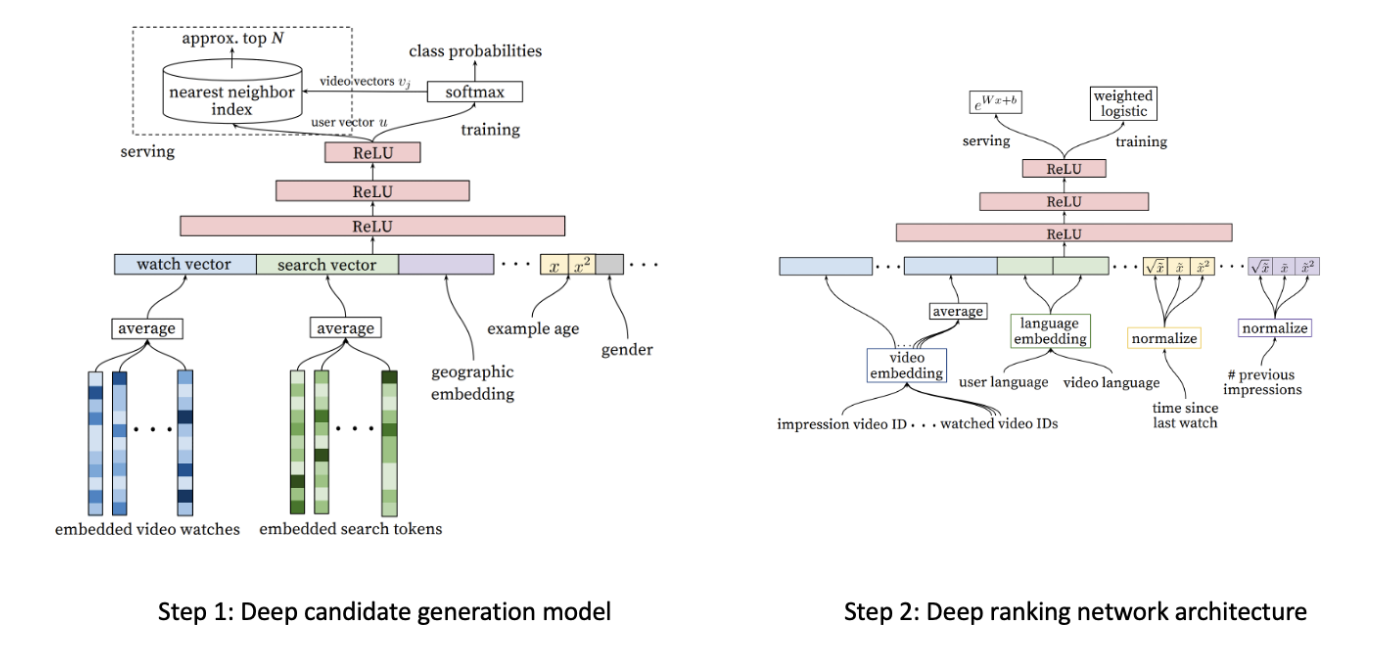

In [ ]:
class YoutubeDNN(torch.nn.Module):
    """
    The match model mentioned in `Deep Neural Networks for YouTube Recommendations` paper.
    It's a DSSM match model trained by global softmax loss on list-wise samples.
    In origin paper, item dnn tower is missing.
    Args:
        user_features (list[Feature Class]): training by the user tower module.
        item_features (list[Feature Class]): training by the embedding table, it's the item id feature.
        neg_item_feature (list[Feature Class]): training by the embedding table, it's the negative items id feature.
        user_params (dict): the params of the User Tower module,
        keys include:`{"dims":list, "activation":str, "dropout":float, "output_layer":bool`}.
        temperature (float): temperature factor for similarity score, default to 1.0.
    """

    def __init__(self, user_features, item_features, neg_item_feature, user_params, temperature=1.0):
        super().__init__()
        self.user_features = user_features
        self.item_features = item_features
        self.neg_item_feature = neg_item_feature
        self.temperature = temperature
        self.user_dims = sum([fea.embed_dim for fea in user_features])
        self.embedding = EmbeddingLayer(user_features + item_features)
        self.user_mlp = MLP(self.user_dims, output_layer=False, **user_params)
        self.mode = None

    def forward(self, x):
        user_embedding = self.user_tower(x)
        item_embedding = self.item_tower(x)
        if self.mode == "user":
            return user_embedding
        if self.mode == "item":
            return item_embedding

        y = torch.mul(user_embedding, item_embedding).sum(dim=2)
        y = y / self.temperature
        return y

    def user_tower(self, x):
        if self.mode == "item":
            return None
        # [batch_size, num_features * deep_dims]
        input_user = self.embedding(x, self.user_features, squeeze_dim=True)
        # [batch_size, 1, embed_dim]
        user_embedding = self.user_mlp(input_user).unsqueeze(1)
        user_embedding = F.normalize(user_embedding, p=2, dim=2)
        if self.mode == "user":
            return user_embedding.squeeze(1)
        return user_embedding

    def item_tower(self, x):
        if self.mode == "user":
            return None
        # [batch_size, 1, embed_dim]
        pos_embedding = self.embedding(x, self.item_features, squeeze_dim=False)
        pos_embedding = F.normalize(pos_embedding, p=2, dim=2)
        # inference embedding mode
        if self.mode == "item":
            # [batch_size, embed_dim]
            return pos_embedding.squeeze(1)
        # [batch_size, n_neg_items, embed_dim]
        neg_embeddings = self.embedding(x, self.neg_item_feature, squeeze_dim=False).squeeze(1)
        neg_embeddings = F.normalize(neg_embeddings, p=2, dim=2)
        # [batch_size, 1 + n_neg_items, embed_dim]
        return torch.cat((pos_embedding, neg_embeddings), dim=1)

In [ ]:
df_train, df_test = generate_seq_feature_match(
    data,
    user_col,
    item_col,
    time_col="timestamp",
    item_attribute_cols=[],
    sample_method=1,
    mode=2,
    neg_ratio=3,
    min_item=0,
)
x_train = gen_model_input(df_train, user_profile, user_col, item_profile, item_col, seq_max_len=50)
y_train = np.array([0] * df_train.shape[0])
x_test = gen_model_input(df_test, user_profile, user_col, item_profile, item_col, seq_max_len=50)

user_cols = ["user_id", "gender", "age", "occupation", "zip"]

user_features = [SparseFeature(name, vocab_size=feature_max_idx[name], embed_dim=16) for name in user_cols]
user_features += [
    SequenceFeature(
        "hist_movie_id", vocab_size=feature_max_idx["movie_id"], embed_dim=16, pooling="mean", shared_with="movie_id"
    )
]

item_features = [SparseFeature("movie_id", vocab_size=feature_max_idx["movie_id"], embed_dim=16)]
neg_item_feature = [
    SequenceFeature(
        "neg_items", vocab_size=feature_max_idx["movie_id"], embed_dim=16, pooling="concat", shared_with="movie_id"
    )
]

all_item = df_to_dict(item_profile)
test_user = x_test

dg = MatchDataGenerator(x=x_train, y=y_train)
train_dl, test_dl, item_dl = dg.generate_dataloader(test_user, all_item, batch_size=512)

generate sequence features: 100%|██████████| 2312/2312 [00:08<00:00, 259.23it/s]


n_train: 595376, n_test: 2312
0 cold start users droped 


In [ ]:
model = YoutubeDNN(user_features, item_features, neg_item_feature, user_params={"dims": [16, 16, 16]}, temperature=0.1)

trainer = MatchTrainer(
    model, mode=2, optimizer_params={"lr": 1e-2, "weight_decay": 1e-5}, n_epoch=1, device="cpu", model_path=save_dir
)

trainer.fit(train_dl)

print("inference embedding")
user_embedding = trainer.inference_embedding(model=model, mode="user", data_loader=test_dl, model_path=save_dir)
item_embedding = trainer.inference_embedding(model=model, mode="item", data_loader=item_dl, model_path=save_dir)
match_evaluation(user_embedding, item_embedding, test_user, all_item, topk=100, raw_id_maps="./saved/raw_id_maps.npy")

epoch: 0


train: 100%|██████████| 1163/1163 [00:37<00:00, 31.09it/s, loss=1.37]


inference embedding


item inference: 100%|██████████| 8/8 [00:00<00:00,  8.49it/s]


defaultdict(list,
            {'NDCG': ['NDCG@100: 0.0005'],
             'MRR': ['MRR@100: 0.0018'],
             'Recall': ['Recall@100: 0.0601'],
             'Hit': ['Hit@100: 0.0601'],
             'Precision': ['Precision@100: 0.0006']})

## LightFM

Kula, M., 2015. Metadata embeddings for user and item cold-start recommendations. arXiv preprint arXiv:1507.08439.

http://ceur-ws.org/Vol-1448/paper4.pdf?ref=https://githubhelp.com

https://github.com/lyst/lightfm

Нейросетевые модели - не всегда самая лучшая опция, в частности, есть довольно сильная модель LightFM, которая обобщает коллабративную фильтрацию для случая с добавлением признаков.


* Это гибридный подход коллаборативной фильтрации и контентной модели, которая предсталвяет эмбеддинги пользователей и эмбеддинги объектов как линейные комбинации из обученных векторов известных признаков - т.е. суммы новых латентных признаков. При этом, это позволяет обучать модель как в режиме без признаков, так и с ними, решая проблему холодного старта (т.к. по новым пользователям и объектам можно использовать их признаки) и проблему слишком разреженных данных (high sparsity problem). Таким образом, LightFM умеет хорошо работает как с плотными, так и с разреженными данными, и, как бонус, кодировать в эмбеддингах признаков семантическую информацию по аналогии с подходами для получения эмбеддингов слов (например, w2v).


*  Формализация.  <br> $U$ - множество пользователей, <br> $I$ - множество объектов, <br> $F^{U}$ - множество признаков пользователей, <br> $F^{I}$- множество признаков объектов. <br>
Все пары $(u, i) \in U × I$ - это объединение всех положительных $S^{+}$ и отрицательных $S^{-}$ интеракций.

Каждый пользователь описан набором заранее известных признаков (мета данных) $f_u \subset F^U$, то же самое для объектов  $f_i \subset F^I$.

Латентное представление пользователя представлено суммой его латентных векторов признаков:

$$q_u = \sum_{j \in f_u} e^U_j$$

Аналогично для объектов: $$p_u = \sum_{j \in f_i} e^I_j$$

Так же, по пользователю и объекту есть смещения (bias):

$$b_u = \sum_{j \in f_u} b^U_j$$

$$b_i = \sum_{j \in f_i} b^I_j$$

Предсказание из модели будет получать через скалярное произведение эмбедингов пользователя и объекта.

$$\hat r_{ui} = f (q_u \cdot p_i + b_u + b_i)$$

Функция f() может быть разной, автор статьи выбрал сигмоиду, поскольку использовал бинарные данные.

$$f(x) = \frac{1}{1 + exp(-x)}$$

Задача оптимизации будет сформулирована как максимизация правдоподобия (данных при параметрах), с обучением модели с помощью стохастического градиентного спуска.

$$L(e^U, e^I, b^U, b^I) = \prod_{(u, i) \in S^+} \hat r_{ui} \cdot  \prod_{(u, i) \in S^-} (1 - \hat r_{ui})$$

In [ ]:
def df_to_tuple_iterator(df: pd.DataFrame):
    """
    :df: pd.DataFrame, interactions dataframe
    returs iterator
    """
    return zip(*df.values.T)


def concat_last_to_list(t):
    return (t[0], list(t[1:])[0])


def df_to_tuple_list_iterator(df):
    return map(concat_last_to_list, zip(*df.values.T))

In [ ]:
data.head()

,user_id,movie_id,rating,timestamp,title,genres,gender,age,occupation,zip,cat_id
456790,2312,790,4,956703932,"Godfather, The (1972)",Action|Crime|Drama,2,3,7,231,1
456672,2312,576,5,956703954,"Silence of the Lambs, The (1991)",Drama|Thriller,2,3,7,231,8
456732,2312,2165,4,956703954,Babe: Pig in the City (1998),Children's|Comedy,2,3,7,231,4
456641,2312,1757,4,956703977,Rain Man (1988),Drama,2,3,7,231,8
456842,2312,1815,5,956703977,Seven Samurai (The Magnificent Seven) (Shichin...,Action|Drama,2,3,7,231,1


In [ ]:
interactions = data[["user_id", "movie_id", "rating", "timestamp"]]
interactions.head()

,user_id,movie_id,rating,timestamp
456790,2312,790,4,956703932
456672,2312,576,5,956703954
456732,2312,2165,4,956703954
456641,2312,1757,4,956703977
456842,2312,1815,5,956703977


In [ ]:
movies_metadata = data[["movie_id", "cat_id", "title"]]
movies_metadata.head(3)

,movie_id,cat_id,title
456790,790,1,"Godfather, The (1972)"
456672,576,8,"Silence of the Lambs, The (1991)"
456732,2165,4,Babe: Pig in the City (1998)


In [ ]:
movies_metadata["movie_id"] = movies_metadata["movie_id"].astype(str)
interactions["movie_id"] = interactions["movie_id"].astype(str)

interactions_filtered = interactions.loc[interactions["movie_id"].isin(movies_metadata["movie_id"])]
print(interactions.shape, interactions_filtered.shape)

(600000, 4) (600000, 4)


In [ ]:
dataset = Dataset()
dataset.fit(interactions["user_id"].unique(), interactions["movie_id"].unique())
lightfm_mapping = dataset.mapping()
lightfm_mapping = {
    "users_mapping": lightfm_mapping[0],
    "user_features_mapping": lightfm_mapping[1],
    "items_mapping": lightfm_mapping[2],
    "item_features_mapping": lightfm_mapping[3],
}
print("user mapper length - ", len(lightfm_mapping["users_mapping"]))
print("user features mapper length - ", len(lightfm_mapping["user_features_mapping"]))
print("movies mapper length - ", len(lightfm_mapping["items_mapping"]))
print("Users movie features mapper length - ", len(lightfm_mapping["item_features_mapping"]))

AttributeError: 'Dataset' object has no attribute 'fit'

In [ ]:
lightfm_mapping["users_inv_mapping"] = {v: k for k, v in lightfm_mapping["users_mapping"].items()}
lightfm_mapping["items_inv_mapping"] = {v: k for k, v in lightfm_mapping["items_mapping"].items()}

In [ ]:
train_mat, train_mat_weights = dataset.build_interactions(
    df_to_tuple_iterator(interactions_filtered[["user_id", "movie_id"]])
)

In [ ]:
train_mat_weights

In [ ]:
interactions_filtered[["user_id", "movie_id"]]

**Зададим параметры LightFM:**

In [ ]:
NO_COMPONENTS = 64
LEARNING_RATE = 0.04
LOSS = "bpr"
MAX_SAMPLED = 5
RANDOM_STATE = 42
EPOCHS = 20

In [ ]:
lfm_model = LightFM(
    no_components=NO_COMPONENTS,
    learning_rate=LEARNING_RATE,
    loss=LOSS,
    max_sampled=MAX_SAMPLED,
    random_state=RANDOM_STATE,
)

In [ ]:
for _ in tqdm_notebook(range(EPOCHS), total=EPOCHS):
    lfm_model.fit_partial(train_mat, num_threads=4)

In [ ]:
# to make sanity-check
top_N = 10
user_id = interactions["user_id"][1000]
row_id = lightfm_mapping["users_mapping"][user_id]
print(f"Rekko for user {user_id}, row number in matrix - {row_id}")

In [ ]:
all_cols = list(lightfm_mapping["items_mapping"].values())
len(all_cols)

In [ ]:
pred = lfm_model.predict(row_id, all_cols, num_threads=4)
pred, pred.shape

In [ ]:
top_cols = np.argpartition(pred, -np.arange(top_N))[-top_N:][::-1]
top_cols

In [ ]:
pred[top_cols]

In [ ]:
pred

In [ ]:
# crate mapper for movieId and title names
item_name_mapper = dict(zip(movies_metadata["movie_id"], movies_metadata["title"]))

In [ ]:
item_name_mapper

In [ ]:
recs = pd.DataFrame({"col_id": top_cols})
recs["movieId"] = recs["col_id"].map(lightfm_mapping["items_inv_mapping"].get).astype(str)
recs["title"] = recs["movieId"].map(item_name_mapper)
recs

In [ ]:
    # Compute top-k metrics
out = topk_metrics(y_true=, y_pred=pred, topKs=10)
out

TypeError: sparse array length is ambiguous; use getnnz() or shape[0]

Источники:

1. Исходная статья DSSM https://posenhuang.github.io/papers/cikm2013_DSSM_fullversion.pdf
2. RecBole https://github.com/RUCAIBox/RecBole
3. https://github.com/datawhalechina/torch-rechub
4. Статья LightFM http://ceur-ws.org/Vol-1448/paper4.pdf?ref=https://githubhelp.com
5. Отличная **библиотека от автора статьи** c примерами запусков - https://github.com/lyst/lightfm

In [ ]:
!pip install rectools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.2/154.2 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 13.1 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
  Attempting uninstall: attrs
    Found existing installation: attrs 24.3.0
    Uninstalling attrs-24.3.0:
      Successfully uninstalled attrs-24.3.0


In [ ]:
# Получим данные датасета KION
%%time
!wget -q https://github.com/irsafilo/KION_DATASET/raw/f69775be31fa5779907cf0a92ddedb70037fb5ae/data_original.zip -O data_original.zip
!unzip -o data_original.zip
!rm data_original.zip

Archive:  data_original.zip
   creating: data_original/
  inflating: data_original/interactions.csv  
  inflating: __MACOSX/data_original/._interactions.csv  
  inflating: data_original/users.csv  
  inflating: __MACOSX/data_original/._users.csv  
  inflating: data_original/items.csv  
  inflating: __MACOSX/data_original/._items.csv  
CPU times: user 112 ms, sys: 9.83 ms, total: 122 ms
Wall time: 11.2 s


In [ ]:
import os
import warnings
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from rectools.metrics import MAP, calc_metrics, MeanInvUserFreq, Serendipity
from rectools.models import ImplicitALSWrapperModel
from rectools import Columns
from rectools.dataset import Dataset
from implicit.als import AlternatingLeastSquares

warnings.filterwarnings("ignore")
os.environ["OPENBLAS_NUM_THREADS"] = "1"  # For implicit ALS
sns.set_theme(style="whitegrid")

In [ ]:
DATA_PATH = Path("data_original")

users = pd.read_csv(DATA_PATH / "users.csv")
items = pd.read_csv(DATA_PATH / "items.csv")
interactions = pd.read_csv(DATA_PATH / "interactions.csv", parse_dates=["last_watch_dt"], nrows=50_000).rename(
    columns={"last_watch_dt": Columns.Datetime},
)

In [ ]:
users.head()

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0


In [ ]:
items.head()

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю..."
4,16268,film,Все решает мгновение,NaN,1978.0,"драмы, спорт, советские, мелодрамы",СССР,NaN,12.0,Ленфильм,Виктор Садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж..."


In [ ]:
interactions.head()

,user_id,item_id,datetime,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [ ]:
# Process interactions
interactions[Columns.Weight] = np.where(interactions["watched_pct"] > 10, 3, 1)

# Split to train / test
max_date = interactions[Columns.Datetime].max()
train = interactions[interactions[Columns.Datetime] < max_date - pd.Timedelta(days=7)].copy()
test = interactions[interactions[Columns.Datetime] >= max_date - pd.Timedelta(days=7)].copy()
train.drop(train.query("total_dur < 300").index, inplace=True)
cold_users = set(test[Columns.User]) - set(train[Columns.User])
test.drop(test[test[Columns.User].isin(cold_users)].index, inplace=True)
test_users = test[Columns.User].unique()
catalog = train[Columns.Item].unique()

# Process user features to the form of a flatten dataframe
users.fillna("Unknown", inplace=True)
users = users.loc[users[Columns.User].isin(train[Columns.User])].copy()
user_features_frames = []
for feature in ["sex", "age", "income"]:
    feature_frame = users.reindex(columns=[Columns.User, feature])
    feature_frame.columns = ["id", "value"]
    feature_frame["feature"] = feature
    user_features_frames.append(feature_frame)
user_features = pd.concat(user_features_frames)

# Process item features to the form of a flatten dataframe
items = items.loc[items[Columns.Item].isin(train[Columns.Item])].copy()
items["genre"] = items["genres"].str.lower().str.replace(", ", ",", regex=False).str.split(",")
genre_feature = items[["item_id", "genre"]].explode("genre")
genre_feature.columns = ["id", "value"]
genre_feature["feature"] = "genre"
content_feature = items.reindex(columns=[Columns.Item, "content_type"])
content_feature.columns = ["id", "value"]
content_feature["feature"] = "content_type"
item_features = pd.concat((genre_feature, content_feature))

In [ ]:
user_features.head()

,id,value,feature
3,721985,Ж,sex
45,407465,М,sex
66,216495,М,sex
87,1072616,Ж,sex
117,859696,Ж,sex


In [ ]:
item_features.head()

,id,value,feature
2,10716,криминал,genre
2,10716,зарубежные,genre
2,10716,триллеры,genre
2,10716,боевики,genre
2,10716,комедии,genre


In [ ]:
dataset_no_features = Dataset.construct(
    interactions_df=train,
)

dataset_full_features = Dataset.construct(
    interactions_df=train,
    user_features_df=user_features,
    cat_user_features=["sex", "age", "income"],
    item_features_df=item_features,
    cat_item_features=["genre", "content_type"],
)

dataset_item_features = Dataset.construct(
    interactions_df=train,
    item_features_df=item_features,
    cat_item_features=["genre", "content_type"],
)

dataset_user_features = Dataset.construct(
    interactions_df=train,
    user_features_df=user_features,
    cat_user_features=["sex", "age", "income"],
)

feature_datasets = {
    "full_features": dataset_full_features,
    "item_features": dataset_item_features,
    "user_features": dataset_user_features,
}

In [ ]:
# Prepare dataset with biases as features

item_biases = pd.DataFrame({"id": catalog, "bias": 1})
user_biases = pd.DataFrame({"id": train[Columns.User].unique(), "bias": 1})

dataset_with_biases = Dataset.construct(
    interactions_df=train,
    user_features_df=user_biases,
    make_dense_user_features=True,
    item_features_df=item_biases,
    make_dense_item_features=True,
)
feature_datasets["biases"] = dataset_with_biases

In [ ]:
metrics_name = {"MAP": MAP, "Serendipity": Serendipity}
metrics = {}
for metric_name, metric in metrics_name.items():
    for k in (1, 5, 10):
        metrics[f"{metric_name}@{k}"] = metric(k=k)

In [ ]:
K_RECOS = 10
NUM_THREADS = 8
RANDOM_STATE = 42
ITERATIONS = 10

In [ ]:
def make_base_model(factors: int, regularization: float, alpha: float, fit_features_together: bool = False):
    return ImplicitALSWrapperModel(
        AlternatingLeastSquares(
            factors=factors,
            regularization=regularization,
            alpha=alpha,
            random_state=RANDOM_STATE,
            use_gpu=False,
            num_threads=NUM_THREADS,
            iterations=ITERATIONS,
        ),
        fit_features_together=fit_features_together,
    )

In [ ]:
alphas = [1, 10, 100]
regularizations = [0.01, 0.1, 0.05]
factors = [32, 64, 128]
results = []
dataset = dataset_no_features

for alpha in alphas:
    for regularization in regularizations:
        for n_factors in factors:
            model_name = f"no_features_factors_{n_factors}_alpha_{alpha}_reg_{regularization}"
            model = make_base_model(factors=n_factors, regularization=regularization, alpha=alpha)
            model.fit(dataset)
            recos = model.recommend(
                users=test_users,
                dataset=dataset,
                k=K_RECOS,
                filter_viewed=True,
            )
            metric_values = calc_metrics(metrics, recos, test, train, catalog)
            metric_values["model"] = model_name
            results.append(metric_values)

In [ ]:
pure_df = pd.DataFrame(results).set_index("model").sort_values(by=["MAP@10", "Serendipity@10"], ascending=False)
pure_df.head(5)

,MAP@1,MAP@5,MAP@10,Serendipity@1,Serendipity@5,Serendipity@10
model,,,,,,
no_features_factors_32_alpha_10_reg_0.01,0.002849,0.007217,0.008215,0.000000,0.000020,0.000022
no_features_factors_32_alpha_10_reg_0.1,0.000000,0.005793,0.006679,0.000000,0.000020,0.000020
no_features_factors_32_alpha_10_reg_0.05,0.000000,0.005745,0.006347,0.000000,0.000020,0.000018
no_features_factors_64_alpha_10_reg_0.05,0.002849,0.004368,0.006081,0.000056,0.000026,0.000020
no_features_factors_128_alpha_1_reg_0.01,0.002849,0.003419,0.005467,0.000050,0.000020,0.000030
no_features_factors_128_alpha_1_reg_0.1,0.002849,0.002849,0.005444,0.000050,0.000010,0.000031
no_features_factors_64_alpha_1_reg_0.01,0.002849,0.002849,0.005333,0.000022,0.000004,0.000028
no_features_factors_64_alpha_1_reg_0.1,0.002849,0.003419,0.005258,0.000022,0.000010,0.000022
no_features_factors_128_alpha_1_reg_0.05,0.002849,0.003419,0.005250,0.000050,0.000020,0.000028


In [ ]:
# Best grid search params for pure iALS models
factors_options = (32, 64, 128)
ALPHA = 10
REG = 0.01

# We have two options for training iALS with features in RecTools
fit_features_together = (True, False)

# We have datasets with different feature selections
feature_datasets.keys()

dict_keys(['full_features', 'item_features', 'user_features', 'biases'])

In [ ]:
features_results = []
for dataset_name, dataset in feature_datasets.items():
    for n_factors in factors_options:
        for features_option in fit_features_together:
            model_name = f"{dataset_name}_factors_{n_factors}_fit_together_{features_option}"
            model = make_base_model(
                factors=n_factors, regularization=REG, alpha=ALPHA, fit_features_together=features_option
            )
            model.fit(dataset)
            recos = model.recommend(
                users=test_users,
                dataset=dataset,
                k=K_RECOS,
                filter_viewed=True,
            )
            metric_values = calc_metrics(metrics, recos, test, train, catalog)
            metric_values["model"] = model_name
            features_results.append(metric_values)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
features_df = (
    pd.DataFrame(features_results).set_index("model").sort_values(by=["MAP@10", "Serendipity@10"], ascending=False)
)
features_df.head(5)

,MAP@1,MAP@5,MAP@10,Serendipity@1,Serendipity@5,Serendipity@10
model,,,,,,
biases_factors_32_fit_together_False,0.009972,0.023267,0.025626,2.045228e-06,0.000002,0.000002
biases_factors_128_fit_together_False,0.008547,0.022365,0.024128,2.045228e-06,0.000010,0.000005
biases_factors_64_fit_together_False,0.005698,0.019136,0.021241,1.363485e-06,0.000001,0.000007
user_features_factors_32_fit_together_False,0.009972,0.018898,0.020521,6.817427e-07,0.000003,0.000002
full_features_factors_32_fit_together_False,0.007123,0.018708,0.019753,0.000000e+00,0.000002,0.000001


In [ ]:
# prepare info for summary plot
no_features_best_models = [
    "no_features_factors_128_alpha_10_reg_0.5",
    "no_features_factors_64_alpha_10_reg_0.5",
    "no_features_factors_32_alpha_10_reg_0.5",
]

pure_df["step"] = "1. pure iALS no features grid search"
pure_df.loc[pure_df.index.isin(no_features_best_models), "step"] = "2. pure iALS no features best models"
features_df["step"] = "3. iALS with user / item features"
all_df = pd.concat([features_df, pure_df])

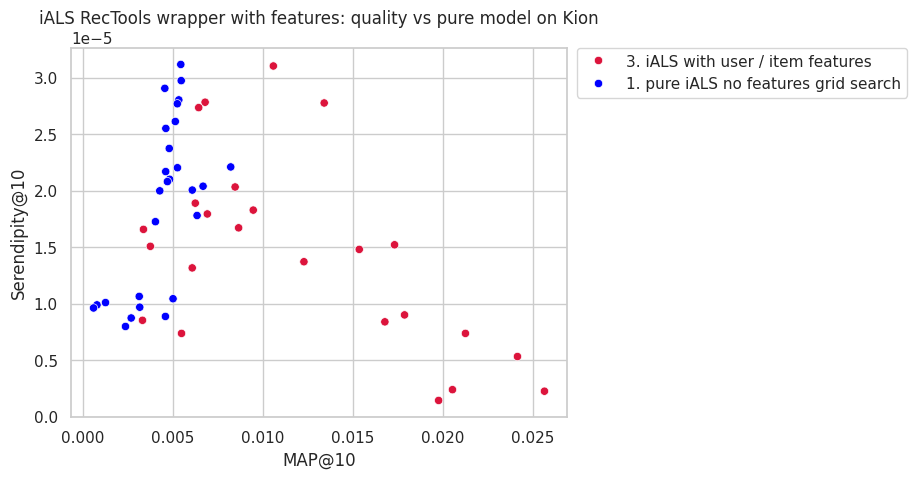

In [ ]:
sns.scatterplot(data=all_df, x="MAP@10", y="Serendipity@10", hue="step", palette=["crimson", "blue", "skyblue"])
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.title("iALS RecTools wrapper with features: quality vs pure model on Kion")
plt.show()

На полных данных будет ещё красивее
